# Phase Determination of HEA Alloys
Tuning of XGBoost Decision Tree model trained on Phase_Data dataset without the inclusion of the SMOTETomak compositions.

In [1]:
!pip install lightgbm
!pip install miceforest

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


## Import Required Libraries

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore")
%matplotlib inline

## Read Data

In [4]:
# Load from xlsx file
df = pd.read_excel('Phase_data.xlsx', na_values="na")

In [5]:
# Check dataframe is as expected
print(df.shape)
df.head()

(1200, 36)


,Al,Co,Cr,Fe,Ni,Cu,Mn,Ti,V,Nb,...,Pt,Y,Pd,Au,dHmix,dSmix,δ,ᐃχ,VEC,Phases
0,0.111,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.222,0.222,...,NaN,NaN,NaN,NaN,-8.395,13.146,3.738,0.050,4.556,BCC
1,0.158,NaN,NaN,NaN,NaN,NaN,NaN,0.215,0.215,0.215,...,NaN,NaN,NaN,NaN,-9.352,13.333,3.863,0.233,4.684,BCC
2,0.588,NaN,NaN,NaN,NaN,NaN,NaN,0.235,0.235,0.235,...,NaN,NaN,NaN,NaN,-4.042,12.708,4.003,0.243,4.882,BCC
3,0.588,NaN,NaN,NaN,NaN,NaN,NaN,0.235,0.235,0.235,...,NaN,NaN,NaN,NaN,-4.817,12.708,3.832,0.050,4.647,BCC
4,0.476,NaN,NaN,NaN,NaN,NaN,NaN,0.239,0.239,NaN,...,NaN,NaN,NaN,NaN,-3.356,12.569,4.018,0.244,4.905,BCC


In [6]:
# Check unique values of target phases
df['Phases'].value_counts()

Phases
MIP        441
BCC        372
FCC        220
FCC_BCC    167
Name: count, dtype: int64

In [7]:
df.dtypes

Al        float64
Co        float64
Cr        float64
Fe        float64
Ni        float64
Cu        float64
Mn        float64
Ti        float64
V         float64
Nb        float64
Mo        float64
Zr        float64
Hf        float64
Ta        float64
W         float64
C         float64
Mg        float64
Zn        float64
Si        float64
Re        float64
N         float64
Li        float64
Sn        float64
Be        float64
B         float64
Ag        float64
Pt        float64
Y         float64
Pd        float64
Au        float64
dHmix     float64
dSmix     float64
δ         float64
ᐃχ        float64
VEC       float64
Phases     object
dtype: object

MIP: 441, BCC: 372, FCC: 220, FCC_BCC : 167


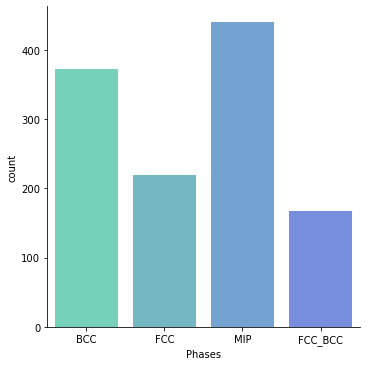

In [8]:
## Visualization of unique values in Target variable
MIP = df[df['Phases']=='MIP'].shape[0]
BCC = df[df['Phases']=='BCC'].shape[0]
FCC = df[df['Phases']=='FCC'].shape[0]
FCC_BCC = df[df['Phases']=='FCC_BCC'].shape[0]
print("MIP: " + str(MIP) + ", BCC: " + str(BCC)  + ", FCC: " + str(FCC)  + ", FCC_BCC : " + str(FCC_BCC ))
sns.catplot(data=df, x="Phases", kind="count", palette="winter_r", alpha=.6)
plt.show()


In [9]:
# define numerical & categorical columns
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'O']
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numeric_features), numeric_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 35 numerical features : ['Al', 'Co', 'Cr', 'Fe', 'Ni', 'Cu', 'Mn', 'Ti', 'V', 'Nb', 'Mo', 'Zr', 'Hf', 'Ta', 'W', 'C', 'Mg', 'Zn', 'Si', 'Re', 'N', 'Li', 'Sn', 'Be', 'B', 'Ag', 'Pt', 'Y', 'Pd', 'Au', 'dHmix', 'dSmix', 'δ', 'ᐃχ', 'VEC']

We have 1 categorical features : ['Phases']


In [10]:
feature_names =  ['Al', 'Co', 'Cr', 'Fe', 'Ni', 'Cu', 'Mn', 'Ti', 'V', 'Nb', 'Mo', 'Zr',
       'Hf', 'Ta', 'W', 'C', 'Mg', 'Zn', 'Si', 'Re', 'N', 'Li', 'Sn', 'Be',
       'B', 'Ag', 'Pt', 'Y', 'Pd', 'Au', 'dHmix', 'dSmix', 'δ', 'ᐃχ', 'VEC', 'Phases']

In [11]:
# convert phase label into numeric label.
df['Phases'].replace({'MIP':0, 'BCC':1, 'FCC':2, 'FCC_BCC':3}, inplace=True) 

In [12]:
# # Check for empty values within df
# for feature in numeric_features:
#     NaN = df[feature].isna().sum()
#     print(feature + f' has {NaN} NaN elements')

In [13]:
df2 = df.copy()
df2.head()

,Al,Co,Cr,Fe,Ni,Cu,Mn,Ti,V,Nb,...,Pt,Y,Pd,Au,dHmix,dSmix,δ,ᐃχ,VEC,Phases
0,0.111,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.222,0.222,...,NaN,NaN,NaN,NaN,-8.395,13.146,3.738,0.050,4.556,1
1,0.158,NaN,NaN,NaN,NaN,NaN,NaN,0.215,0.215,0.215,...,NaN,NaN,NaN,NaN,-9.352,13.333,3.863,0.233,4.684,1
2,0.588,NaN,NaN,NaN,NaN,NaN,NaN,0.235,0.235,0.235,...,NaN,NaN,NaN,NaN,-4.042,12.708,4.003,0.243,4.882,1
3,0.588,NaN,NaN,NaN,NaN,NaN,NaN,0.235,0.235,0.235,...,NaN,NaN,NaN,NaN,-4.817,12.708,3.832,0.050,4.647,1
4,0.476,NaN,NaN,NaN,NaN,NaN,NaN,0.239,0.239,NaN,...,NaN,NaN,NaN,NaN,-3.356,12.569,4.018,0.244,4.905,1


In [14]:
imputer = KNNImputer(n_neighbors=10)
df_imp = imputer.fit_transform(df2)
df_afterimp = pd.DataFrame(df_imp, columns=feature_names[0:36])

In [15]:
#we can to reduce the skewing from outliers so we cap the values that fall out of 3 standard deviations
def ZScore_capping(df, cols, threshold = 3):
    for col in cols:
        mean_col = df[col].mean()
        std_col = threshold * df[col].std()
        upper_limit = mean_col + std_col
        lower_limit = mean_col - std_col
        
        df[col] = np.where(df[col] > upper_limit, upper_limit, np.where(df[col] < lower_limit, lower_limit, df[col]))

In [16]:
ZScore_capping(df_afterimp, numeric_features) #adjusting the data frame to cap outliers

In [17]:
df = df_afterimp.copy()

In [18]:
Al_trans = np.log(df['Al'])
Co_trans = np.log(df['Co'])
Cr_trans = np.log(df['Cr'])
Fe_trans = np.log(df['Fe'])
Ni_trans = np.log(df['Ni'])
Cu_trans = np.log(df['Cu'])
Mn_trans = np.log(df['Mn'])
Ti_trans = np.log(df['Ti'])
V_trans = np.log(df['V'])
Nb_trans = np.log(df['Nb'])
Mo_trans = np.log(df['Mo'])
Zr_trans = np.log(df['Zr'])
Hf_trans = np.log(df['Hf'])
Ta_trans = np.log(df['Ta'])
W_trans = np.log(df['W'])
C_trans = np.log(df['C'])
Mg_trans = np.log(df['Mg'])
Zn_trans = np.log(df['Zn'])
Si_trans = np.log(df['Si'])
Re_trans = np.log(df['Re'])
N_trans = np.log(df['N'])
Li_trans = np.log(df['Li'])
Sn_trans = np.log(df['Sn'])
Be_trans = np.log(df['Be'])
B_trans = np.log(df['B'])
Ag_trans = np.log(df['Ag'])
Pt_trans = np.log(df['Pt'])
Y_trans = np.log(df['Y'])
Pd_trans = np.log(df['Pd'])
Au_trans = np.log(df['Au'])
#dHmix_trans = np.log(df2['dHmix'])
dSmix_trans = np.log(df['dSmix']) 
Atom_Size_Diff_trans = np.log(df['δ'])
Elect_Diff_trans = np.log(df['ᐃχ'])
VEC_trans = np.log(df['VEC'])

In [19]:
df_final = pd.DataFrame(pd.concat([Al_trans, Co_trans, Cr_trans, Fe_trans, Ni_trans, Cu_trans, Mn_trans, 
Ti_trans, V_trans,Nb_trans, Mo_trans, Zr_trans, Hf_trans, Ta_trans, W_trans, C_trans, Mg_trans, Zn_trans, Si_trans, Re_trans, N_trans, 
Li_trans, Sn_trans, Be_trans, B_trans, Ag_trans, Pt_trans, Y_trans, Pd_trans, Au_trans, df2['dHmix'], dSmix_trans, Atom_Size_Diff_trans, 
Elect_Diff_trans, VEC_trans, df2['Phases']], axis=1))
df_final.head()

,Al,Co,Cr,Fe,Ni,Cu,Mn,Ti,V,Nb,...,Pt,Y,Pd,Au,dHmix,dSmix,δ,ᐃχ,VEC,Phases
0,-2.198225,-1.445195,-0.998586,-1.275111,-1.738977,-1.192044,-1.534794,-1.505078,-1.505078,-1.505078,...,-1.609438,-1.806873,-1.203973,-1.789761,-8.395,2.576118,1.318551,-2.995732,1.516445,1
1,-1.845160,-1.582796,-1.289894,-1.427116,-1.581823,-1.543650,-1.541312,-1.537117,-1.537117,-1.537117,...,-1.609438,-1.806873,-1.203973,-1.789761,-9.352,2.590242,1.351444,-1.456717,1.544152,1
2,-0.531028,-1.595535,-1.283377,-1.352473,-1.621005,-0.931404,-1.552113,-1.448170,-1.448170,-1.448170,...,-1.609438,-1.806873,-1.203973,-1.789761,-4.042,2.542232,1.387044,-1.414694,1.585555,1
3,-0.531028,-1.581336,-1.375552,-1.322381,-1.565421,-1.119325,-1.539446,-1.448170,-1.448170,-1.448170,...,-1.609438,-1.806873,-1.203973,-1.789761,-4.817,2.542232,1.343387,-2.995732,1.536222,1
4,-0.742337,-1.716466,-1.388296,-1.358679,-1.543650,-0.886004,-1.566378,-1.431292,-1.431292,-1.480166,...,-1.609438,-1.806873,-1.203973,-1.789761,-3.356,2.531233,1.390784,-1.410587,1.590255,1


In [20]:
X= df_final.drop('Phases', axis=1)
y = df_final['Phases']

In [21]:
full_data= df_final.copy()
X_full= full_data.drop('Phases', axis=1)
y_full = full_data['Phases']

All the data is not normally distributed, so, we apply robust scaler:

In [22]:
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

## How to best impute Null values in the data:
The original authors compared 5 methods of substituting the NaN values, through 5 "Experiments" to see which technique resulted in the best model accuracy. Those 5 models are as follows:

1. KNN Imputer with best `n_neighbors` values determined with cross-validation score
    - `KNNImputer(n_neighbors)`
        - `n_neighbors` determined by best `cross_val_score`
2. Simple Imputer with Strategy Median
    - `SimpleImputer(strategy='median')`
3. MICE for Imputing Null Values
    -  `miceforest.ImputationKernel()`
4. Simple Imputer with Strategy Constant
    -  `SimpleImputer(strategy='constant', fill_value=0)`
5. Simple Imputer with Strategy Mean
    -  `SimpleImputer(strategy='mean')`
    
#### Our Plan:
Replicate the original author's work in comparing those 5 methods of imputation, but also include the `IterativeImputer` technique. Each respective Imputation technique will be marked by a DataFrame label of `X_β` where β represents which of the 6 techniques was used.


### KNN Imputer

In [23]:
# KNN Imputer
results = []

# imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1, 3, 4, 7, 9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=1)
    results.append(scores)
    print('n_neighbors=%s || accuracy (%.4f)' % (s, mean(scores)))


n_neighbors=1 || accuracy (0.5617)
n_neighbors=3 || accuracy (0.5617)
n_neighbors=4 || accuracy (0.5617)
n_neighbors=7 || accuracy (0.5617)
n_neighbors=9 || accuracy (0.5617)


In [24]:
### Pipeline for KNN Imputer
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN Imputer with selected K-value: 3 has highest accuracy
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('RobustScaler', RobustScaler())
])

In [25]:
X_knn = knn_pipeline.fit_transform(X)

### Simple Imputer with Strategy Median

In [26]:
### Pipeline for Simple Imputer with Strategy Median
num_features = X.select_dtypes(exclude="object").columns

# Fit the Simple Imputer with Strategy Median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [27]:
X_median = median_pipeline.fit_transform(X)

### MICE for Imputing Null Values

In [28]:
##### NOTE:For some reason miceforest won't work for me, skipping for time.
import miceforest as mf
# import lightgbm as lgb

X_mice = X.copy()
kernel = mf.ImputationKernel(
X_mice,
save_all_iterations=True,
random_state=1989
)
kernel.mice(3) # Run the MICE algorithm for 3 iterations

### Simple Imputer with Strategy Constant

In [29]:
# Create a pipeline with simple imputer with strategy constant and fill value 0
constant_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('RobustScaler', RobustScaler())
])

In [30]:
X_const = constant_pipeline.fit_transform(X)

### Simple Imputer with Strategy Mean

In [31]:
# Create a pipeline with Simple imputer with strategy mean
mean_pipeline = Pipeline(steps=[
    ('Imputer', SimpleImputer(strategy='mean')),
    ('RobustScaler', RobustScaler())
])

In [32]:
X_mean = mean_pipeline.fit_transform(X)

### Iterative Imputer

In [33]:
# Create a pipeline with Iterative imputer
iter_pipeline = Pipeline(steps=[
    ('Imputer', IterativeImputer(random_state=0)),
    ('RobustScaler', RobustScaler())
])

In [34]:
X_iter = iter_pipeline.fit_transform(X)

## Create Functions for model training and evaluation

In [35]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted,average='weighted') # Calculate F1-score
    precision = precision_score(true, predicted, average='weighted') # Calculate Precision
    recall = recall_score(true, predicted, average='weighted')  # Calculate Recall
   
    return acc, f1 , precision, recall

In [36]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
       

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall=evaluate_clf(y_train ,y_train_pred)
        

        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall=evaluate_clf(y_test, y_test_pred)

       
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
         
       

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
       
       
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

## Choose which Models to evaluate in a dictionary

In [37]:
# Dictionary which contains models for experiment
models = {
    
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Neighbors Classifier": KNeighborsClassifier(), # too many features to run this model's predictions on my personal laptop
    "XGBClassifier": XGBClassifier(), 
    "SVM": SVC()
    
}

## Evaluate Models for each Impute type

In [38]:
# X_train, X_test, y_train, y_test = train_test_split(X_knn,y,test_size=0.2,random_state=42)
# model = KNeighborsClassifier()
# model.fit(X_train, y_train)# Train model

In [39]:
# # Make predictions
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

In [40]:
# KNN Imputer with n_neighbors = 3:
report_knn = evaluate_models(X_knn, y, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.8000
- F1 score: 0.8007
- Precision: 0.8051
- Recall: 0.8000


Decision Tree
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.7000
- F1 score: 0.6998
- Precision: 0.6997
- Recall: 0.7000


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.7760
- F1 score: 0.7753
- Precision: 0.7758
- Recall: 0.7760
----------------------------------
Model performance for Test set
- Accuracy: 0.7167
- F1 score: 0.7174
- Precision: 0.7222
- Recall: 0.7167


XGBClassifier
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set


In [41]:
# Simple Imputer with Strategy Median:
report_median = evaluate_models(X_median, y, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.7917
- F1 score: 0.7919
- Precision: 0.7984
- Recall: 0.7917


Decision Tree
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.6750
- F1 score: 0.6747
- Precision: 0.6760
- Recall: 0.6750


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.7760
- F1 score: 0.7753
- Precision: 0.7758
- Recall: 0.7760
----------------------------------
Model performance for Test set
- Accuracy: 0.7167
- F1 score: 0.7174
- Precision: 0.7222
- Recall: 0.7167


XGBClassifier
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set


In [42]:
# # MICE for Imputing Null values:
report_mice = evaluate_models(X_mice, y, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.8042
- F1 score: 0.8052
- Precision: 0.8105
- Recall: 0.8042


Decision Tree
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.7000
- F1 score: 0.7001
- Precision: 0.7032
- Recall: 0.7000


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.7615
- F1 score: 0.7603
- Precision: 0.7613
- Recall: 0.7615
----------------------------------
Model performance for Test set
- Accuracy: 0.6542
- F1 score: 0.6527
- Precision: 0.6567
- Recall: 0.6542


XGBClassifier
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set


In [43]:
# Simple Imputer with Strategy Constant:
report_const = evaluate_models(X_const, y, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.8167
- F1 score: 0.8175
- Precision: 0.8251
- Recall: 0.8167


Decision Tree
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.6708
- F1 score: 0.6701
- Precision: 0.6699
- Recall: 0.6708


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.7760
- F1 score: 0.7753
- Precision: 0.7758
- Recall: 0.7760
----------------------------------
Model performance for Test set
- Accuracy: 0.7167
- F1 score: 0.7174
- Precision: 0.7222
- Recall: 0.7167


XGBClassifier
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set


In [44]:
# Simple Imputer with Strategy Mean:
report_mean = evaluate_models(X_mean, y, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.8042
- F1 score: 0.8047
- Precision: 0.8121
- Recall: 0.8042


Decision Tree
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.6958
- F1 score: 0.6953
- Precision: 0.6966
- Recall: 0.6958


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.7760
- F1 score: 0.7753
- Precision: 0.7758
- Recall: 0.7760
----------------------------------
Model performance for Test set
- Accuracy: 0.7167
- F1 score: 0.7174
- Precision: 0.7222
- Recall: 0.7167


XGBClassifier
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set


In [45]:
# Iterative Imputer:
report_iter = evaluate_models(X_iter, y, models)

Random Forest
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.7833
- F1 score: 0.7841
- Precision: 0.7905
- Recall: 0.7833


Decision Tree
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set
- Accuracy: 0.6833
- F1 score: 0.6841
- Precision: 0.6868
- Recall: 0.6833


K-Neighbors Classifier
Model performance for Training set
- Accuracy: 0.7760
- F1 score: 0.7753
- Precision: 0.7758
- Recall: 0.7760
----------------------------------
Model performance for Test set
- Accuracy: 0.7167
- F1 score: 0.7174
- Precision: 0.7222
- Recall: 0.7167


XGBClassifier
Model performance for Training set
- Accuracy: 0.9990
- F1 score: 0.9990
- Precision: 0.9990
- Recall: 0.9990
----------------------------------
Model performance for Test set


## Hyper-parameter tuning of RFC Model

In [46]:
from scipy.sparse.construct import random
import optuna
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    param = {
        'random_state': trial.suggest_categorical('random_state', [0, 25, 100, None]),
       " criterion" : trial.suggest_int('min_samples_split', 1,10),
        "max_depth" : trial.suggest_int("max_depth", 2, 32, log=True),
        "n_estimators" : trial.suggest_int("n_estimators", 100,1000),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1,10)
        # 'bootstrap': trial.suggest_categorical('bootstrap' , [True, False]),
        # 'max_features': trial.suggest_categorical("max_features" , ['auto', 'sqrt'])
    }

    suggested_random_state = param['random_state']  # also use the suggested random state value in train_test_split()
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.2, shuffle=True, random_state=suggested_random_state)
    clf = RandomForestClassifier()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average='weighted') # Calculate F1-score #average='weighted'
    precision = precision_score(y_pred, y_test, average='weighted') # Calculate Precision
    recall = recall_score(y_pred, y_test, average='weighted')  # Calculate Recall
    print(f"Model Accuracy: {round(acc, 6)}")
    print(f"Model F1-score: {round(f1, 6)}")
    print(f"Model precision-score: {round(precision, 6)}")
    print(f"Model recall-score: {round(recall, 6)}")

    print(f"Model Parameters: {param}")
    
    return acc  # return our objective value
    return f1
    return precision
    return recall

if __name__ == "__main__":
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler()
    )
    study.optimize(objective, n_trials=50)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-06-10 08:36:18,583] A new study created in memory with name: no-name-9af7365f-2808-46e1-9441-2d13a1828be3
[I 2024-06-10 08:36:18,867] Trial 0 finished with value: 0.7791666666666667 and parameters: {'random_state': 25, 'min_samples_split': 1, 'max_depth': 2, 'n_estimators': 696, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7791666666666667.


Model Accuracy: 0.779167
Model F1-score: 0.778727
Model precision-score: 0.784938
Model recall-score: 0.779167
Model Parameters: {'random_state': 25, ' criterion': 1, 'max_depth': 2, 'n_estimators': 696, 'min_samples_leaf': 3}


[I 2024-06-10 08:36:19,143] Trial 1 finished with value: 0.7875 and parameters: {'random_state': 25, 'min_samples_split': 10, 'max_depth': 22, 'n_estimators': 390, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.7875.


Model Accuracy: 0.7875
Model F1-score: 0.787064
Model precision-score: 0.796706
Model recall-score: 0.7875
Model Parameters: {'random_state': 25, ' criterion': 10, 'max_depth': 22, 'n_estimators': 390, 'min_samples_leaf': 8}


[I 2024-06-10 08:36:19,361] Trial 2 finished with value: 0.7708333333333334 and parameters: {'random_state': 25, 'min_samples_split': 4, 'max_depth': 3, 'n_estimators': 367, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7875.


Model Accuracy: 0.770833
Model F1-score: 0.769523
Model precision-score: 0.776474
Model recall-score: 0.770833
Model Parameters: {'random_state': 25, ' criterion': 4, 'max_depth': 3, 'n_estimators': 367, 'min_samples_leaf': 1}


[I 2024-06-10 08:36:19,598] Trial 3 finished with value: 0.8041666666666667 and parameters: {'random_state': 0, 'min_samples_split': 10, 'max_depth': 24, 'n_estimators': 467, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.8041666666666667.


Model Accuracy: 0.804167
Model F1-score: 0.802997
Model precision-score: 0.809056
Model recall-score: 0.804167
Model Parameters: {'random_state': 0, ' criterion': 10, 'max_depth': 24, 'n_estimators': 467, 'min_samples_leaf': 3}


[I 2024-06-10 08:36:19,805] Trial 4 finished with value: 0.7958333333333333 and parameters: {'random_state': None, 'min_samples_split': 8, 'max_depth': 9, 'n_estimators': 693, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8041666666666667.


Model Accuracy: 0.795833
Model F1-score: 0.79553
Model precision-score: 0.796996
Model recall-score: 0.795833
Model Parameters: {'random_state': None, ' criterion': 8, 'max_depth': 9, 'n_estimators': 693, 'min_samples_leaf': 2}


[I 2024-06-10 08:36:20,014] Trial 5 finished with value: 0.8166666666666667 and parameters: {'random_state': None, 'min_samples_split': 3, 'max_depth': 8, 'n_estimators': 789, 'min_samples_leaf': 7}. Best is trial 5 with value: 0.8166666666666667.


Model Accuracy: 0.816667
Model F1-score: 0.818376
Model precision-score: 0.823334
Model recall-score: 0.816667
Model Parameters: {'random_state': None, ' criterion': 3, 'max_depth': 8, 'n_estimators': 789, 'min_samples_leaf': 7}


[I 2024-06-10 08:36:20,224] Trial 6 finished with value: 0.8166666666666667 and parameters: {'random_state': None, 'min_samples_split': 7, 'max_depth': 2, 'n_estimators': 565, 'min_samples_leaf': 9}. Best is trial 5 with value: 0.8166666666666667.


Model Accuracy: 0.816667
Model F1-score: 0.816987
Model precision-score: 0.824879
Model recall-score: 0.816667
Model Parameters: {'random_state': None, ' criterion': 7, 'max_depth': 2, 'n_estimators': 565, 'min_samples_leaf': 9}


[I 2024-06-10 08:36:20,435] Trial 7 finished with value: 0.825 and parameters: {'random_state': None, 'min_samples_split': 9, 'max_depth': 2, 'n_estimators': 679, 'min_samples_leaf': 3}. Best is trial 7 with value: 0.825.


Model Accuracy: 0.825
Model F1-score: 0.826643
Model precision-score: 0.833034
Model recall-score: 0.825
Model Parameters: {'random_state': None, ' criterion': 9, 'max_depth': 2, 'n_estimators': 679, 'min_samples_leaf': 3}


[I 2024-06-10 08:36:20,647] Trial 8 finished with value: 0.8333333333333334 and parameters: {'random_state': None, 'min_samples_split': 7, 'max_depth': 3, 'n_estimators': 158, 'min_samples_leaf': 3}. Best is trial 8 with value: 0.8333333333333334.


Model Accuracy: 0.833333
Model F1-score: 0.833591
Model precision-score: 0.837113
Model recall-score: 0.833333
Model Parameters: {'random_state': None, ' criterion': 7, 'max_depth': 3, 'n_estimators': 158, 'min_samples_leaf': 3}


[I 2024-06-10 08:36:20,855] Trial 9 finished with value: 0.775 and parameters: {'random_state': 25, 'min_samples_split': 8, 'max_depth': 23, 'n_estimators': 759, 'min_samples_leaf': 6}. Best is trial 8 with value: 0.8333333333333334.


Model Accuracy: 0.775
Model F1-score: 0.775095
Model precision-score: 0.785569
Model recall-score: 0.775
Model Parameters: {'random_state': 25, ' criterion': 8, 'max_depth': 23, 'n_estimators': 759, 'min_samples_leaf': 6}


[I 2024-06-10 08:36:21,078] Trial 10 finished with value: 0.8333333333333334 and parameters: {'random_state': 100, 'min_samples_split': 6, 'max_depth': 4, 'n_estimators': 224, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.8333333333333334.


Model Accuracy: 0.833333
Model F1-score: 0.832442
Model precision-score: 0.835996
Model recall-score: 0.833333
Model Parameters: {'random_state': 100, ' criterion': 6, 'max_depth': 4, 'n_estimators': 224, 'min_samples_leaf': 5}


[I 2024-06-10 08:36:21,300] Trial 11 finished with value: 0.8291666666666667 and parameters: {'random_state': 100, 'min_samples_split': 6, 'max_depth': 4, 'n_estimators': 149, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.8333333333333334.


Model Accuracy: 0.829167
Model F1-score: 0.827419
Model precision-score: 0.82986
Model recall-score: 0.829167
Model Parameters: {'random_state': 100, ' criterion': 6, 'max_depth': 4, 'n_estimators': 149, 'min_samples_leaf': 5}


[I 2024-06-10 08:36:21,521] Trial 12 finished with value: 0.8333333333333334 and parameters: {'random_state': 100, 'min_samples_split': 5, 'max_depth': 5, 'n_estimators': 107, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.8333333333333334.


Model Accuracy: 0.833333
Model F1-score: 0.831765
Model precision-score: 0.838149
Model recall-score: 0.833333
Model Parameters: {'random_state': 100, ' criterion': 5, 'max_depth': 5, 'n_estimators': 107, 'min_samples_leaf': 5}


[I 2024-06-10 08:36:21,743] Trial 13 finished with value: 0.8291666666666667 and parameters: {'random_state': 100, 'min_samples_split': 6, 'max_depth': 4, 'n_estimators': 245, 'min_samples_leaf': 4}. Best is trial 8 with value: 0.8333333333333334.


Model Accuracy: 0.829167
Model F1-score: 0.82792
Model precision-score: 0.831832
Model recall-score: 0.829167
Model Parameters: {'random_state': 100, ' criterion': 6, 'max_depth': 4, 'n_estimators': 245, 'min_samples_leaf': 4}


[I 2024-06-10 08:36:21,964] Trial 14 finished with value: 0.8125 and parameters: {'random_state': 0, 'min_samples_split': 4, 'max_depth': 6, 'n_estimators': 272, 'min_samples_leaf': 10}. Best is trial 8 with value: 0.8333333333333334.


Model Accuracy: 0.8125
Model F1-score: 0.811759
Model precision-score: 0.817433
Model recall-score: 0.8125
Model Parameters: {'random_state': 0, ' criterion': 4, 'max_depth': 6, 'n_estimators': 272, 'min_samples_leaf': 10}


[I 2024-06-10 08:36:22,186] Trial 15 finished with value: 0.8208333333333333 and parameters: {'random_state': 100, 'min_samples_split': 7, 'max_depth': 12, 'n_estimators': 241, 'min_samples_leaf': 1}. Best is trial 8 with value: 0.8333333333333334.


Model Accuracy: 0.820833
Model F1-score: 0.820249
Model precision-score: 0.822988
Model recall-score: 0.820833
Model Parameters: {'random_state': 100, ' criterion': 7, 'max_depth': 12, 'n_estimators': 241, 'min_samples_leaf': 1}


[I 2024-06-10 08:36:22,407] Trial 16 finished with value: 0.8375 and parameters: {'random_state': 100, 'min_samples_split': 2, 'max_depth': 3, 'n_estimators': 890, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.8375
Model F1-score: 0.837479
Model precision-score: 0.838215
Model recall-score: 0.8375
Model Parameters: {'random_state': 100, ' criterion': 2, 'max_depth': 3, 'n_estimators': 890, 'min_samples_leaf': 6}


[I 2024-06-10 08:36:22,628] Trial 17 finished with value: 0.7875 and parameters: {'random_state': None, 'min_samples_split': 1, 'max_depth': 3, 'n_estimators': 922, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.7875
Model F1-score: 0.792488
Model precision-score: 0.805462
Model recall-score: 0.7875
Model Parameters: {'random_state': None, ' criterion': 1, 'max_depth': 3, 'n_estimators': 922, 'min_samples_leaf': 6}


[I 2024-06-10 08:36:22,851] Trial 18 finished with value: 0.8125 and parameters: {'random_state': 0, 'min_samples_split': 2, 'max_depth': 3, 'n_estimators': 929, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.8125
Model F1-score: 0.810981
Model precision-score: 0.816092
Model recall-score: 0.8125
Model Parameters: {'random_state': 0, ' criterion': 2, 'max_depth': 3, 'n_estimators': 929, 'min_samples_leaf': 7}


[I 2024-06-10 08:36:23,071] Trial 19 finished with value: 0.8375 and parameters: {'random_state': 100, 'min_samples_split': 3, 'max_depth': 10, 'n_estimators': 995, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.8375
Model F1-score: 0.836797
Model precision-score: 0.838713
Model recall-score: 0.8375
Model Parameters: {'random_state': 100, ' criterion': 3, 'max_depth': 10, 'n_estimators': 995, 'min_samples_leaf': 4}


[I 2024-06-10 08:36:23,293] Trial 20 finished with value: 0.8291666666666667 and parameters: {'random_state': 100, 'min_samples_split': 3, 'max_depth': 15, 'n_estimators': 998, 'min_samples_leaf': 7}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.829167
Model F1-score: 0.828581
Model precision-score: 0.831088
Model recall-score: 0.829167
Model Parameters: {'random_state': 100, ' criterion': 3, 'max_depth': 15, 'n_estimators': 998, 'min_samples_leaf': 7}


[I 2024-06-10 08:36:23,517] Trial 21 finished with value: 0.8291666666666667 and parameters: {'random_state': 100, 'min_samples_split': 2, 'max_depth': 13, 'n_estimators': 858, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.829167
Model F1-score: 0.827837
Model precision-score: 0.831757
Model recall-score: 0.829167
Model Parameters: {'random_state': 100, ' criterion': 2, 'max_depth': 13, 'n_estimators': 858, 'min_samples_leaf': 4}


[I 2024-06-10 08:36:23,739] Trial 22 finished with value: 0.8375 and parameters: {'random_state': 100, 'min_samples_split': 4, 'max_depth': 7, 'n_estimators': 570, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.8375
Model F1-score: 0.836707
Model precision-score: 0.83927
Model recall-score: 0.8375
Model Parameters: {'random_state': 100, ' criterion': 4, 'max_depth': 7, 'n_estimators': 570, 'min_samples_leaf': 4}


[I 2024-06-10 08:36:23,960] Trial 23 finished with value: 0.8375 and parameters: {'random_state': 100, 'min_samples_split': 4, 'max_depth': 10, 'n_estimators': 997, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.8375
Model F1-score: 0.836411
Model precision-score: 0.839555
Model recall-score: 0.8375
Model Parameters: {'random_state': 100, ' criterion': 4, 'max_depth': 10, 'n_estimators': 997, 'min_samples_leaf': 4}


[I 2024-06-10 08:36:24,181] Trial 24 finished with value: 0.8333333333333334 and parameters: {'random_state': 100, 'min_samples_split': 3, 'max_depth': 6, 'n_estimators': 566, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.833333
Model F1-score: 0.832117
Model precision-score: 0.834851
Model recall-score: 0.833333
Model Parameters: {'random_state': 100, ' criterion': 3, 'max_depth': 6, 'n_estimators': 566, 'min_samples_leaf': 6}


[I 2024-06-10 08:36:24,403] Trial 25 finished with value: 0.8083333333333333 and parameters: {'random_state': 100, 'min_samples_split': 2, 'max_depth': 7, 'n_estimators': 844, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.808333
Model F1-score: 0.807342
Model precision-score: 0.811393
Model recall-score: 0.808333
Model Parameters: {'random_state': 100, ' criterion': 2, 'max_depth': 7, 'n_estimators': 844, 'min_samples_leaf': 4}


[I 2024-06-10 08:36:24,626] Trial 26 finished with value: 0.8291666666666667 and parameters: {'random_state': 100, 'min_samples_split': 5, 'max_depth': 18, 'n_estimators': 875, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.829167
Model F1-score: 0.828802
Model precision-score: 0.831236
Model recall-score: 0.829167
Model Parameters: {'random_state': 100, ' criterion': 5, 'max_depth': 18, 'n_estimators': 875, 'min_samples_leaf': 2}


[I 2024-06-10 08:36:24,849] Trial 27 finished with value: 0.8208333333333333 and parameters: {'random_state': 100, 'min_samples_split': 3, 'max_depth': 12, 'n_estimators': 767, 'min_samples_leaf': 8}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.820833
Model F1-score: 0.820379
Model precision-score: 0.821856
Model recall-score: 0.820833
Model Parameters: {'random_state': 100, ' criterion': 3, 'max_depth': 12, 'n_estimators': 767, 'min_samples_leaf': 8}


[I 2024-06-10 08:36:25,071] Trial 28 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 1, 'max_depth': 32, 'n_estimators': 617, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.825
Model F1-score: 0.823669
Model precision-score: 0.827047
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 1, 'max_depth': 32, 'n_estimators': 617, 'min_samples_leaf': 5}


[I 2024-06-10 08:36:25,293] Trial 29 finished with value: 0.8333333333333334 and parameters: {'random_state': 100, 'min_samples_split': 2, 'max_depth': 5, 'n_estimators': 952, 'min_samples_leaf': 2}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.833333
Model F1-score: 0.832018
Model precision-score: 0.83343
Model recall-score: 0.833333
Model Parameters: {'random_state': 100, ' criterion': 2, 'max_depth': 5, 'n_estimators': 952, 'min_samples_leaf': 2}


[I 2024-06-10 08:36:25,517] Trial 30 finished with value: 0.8083333333333333 and parameters: {'random_state': 0, 'min_samples_split': 4, 'max_depth': 9, 'n_estimators': 478, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.808333
Model F1-score: 0.806834
Model precision-score: 0.812844
Model recall-score: 0.808333
Model Parameters: {'random_state': 0, ' criterion': 4, 'max_depth': 9, 'n_estimators': 478, 'min_samples_leaf': 4}


[I 2024-06-10 08:36:25,740] Trial 31 finished with value: 0.8375 and parameters: {'random_state': 100, 'min_samples_split': 4, 'max_depth': 10, 'n_estimators': 959, 'min_samples_leaf': 4}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.8375
Model F1-score: 0.836032
Model precision-score: 0.839774
Model recall-score: 0.8375
Model Parameters: {'random_state': 100, ' criterion': 4, 'max_depth': 10, 'n_estimators': 959, 'min_samples_leaf': 4}


[I 2024-06-10 08:36:25,993] Trial 32 finished with value: 0.8166666666666667 and parameters: {'random_state': 100, 'min_samples_split': 5, 'max_depth': 7, 'n_estimators': 996, 'min_samples_leaf': 5}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.816667
Model F1-score: 0.815338
Model precision-score: 0.820105
Model recall-score: 0.816667
Model Parameters: {'random_state': 100, ' criterion': 5, 'max_depth': 7, 'n_estimators': 996, 'min_samples_leaf': 5}


[I 2024-06-10 08:36:26,256] Trial 33 finished with value: 0.7708333333333334 and parameters: {'random_state': 25, 'min_samples_split': 3, 'max_depth': 10, 'n_estimators': 817, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.770833
Model F1-score: 0.769936
Model precision-score: 0.778438
Model recall-score: 0.770833
Model Parameters: {'random_state': 25, ' criterion': 3, 'max_depth': 10, 'n_estimators': 817, 'min_samples_leaf': 3}


[I 2024-06-10 08:36:26,514] Trial 34 finished with value: 0.8375 and parameters: {'random_state': 100, 'min_samples_split': 4, 'max_depth': 16, 'n_estimators': 913, 'min_samples_leaf': 6}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.8375
Model F1-score: 0.835865
Model precision-score: 0.839107
Model recall-score: 0.8375
Model Parameters: {'random_state': 100, ' criterion': 4, 'max_depth': 16, 'n_estimators': 913, 'min_samples_leaf': 6}


[I 2024-06-10 08:36:26,739] Trial 35 finished with value: 0.7875 and parameters: {'random_state': 25, 'min_samples_split': 1, 'max_depth': 8, 'n_estimators': 371, 'min_samples_leaf': 3}. Best is trial 16 with value: 0.8375.


Model Accuracy: 0.7875
Model F1-score: 0.787702
Model precision-score: 0.797645
Model recall-score: 0.7875
Model Parameters: {'random_state': 25, ' criterion': 1, 'max_depth': 8, 'n_estimators': 371, 'min_samples_leaf': 3}


[I 2024-06-10 08:36:26,966] Trial 36 finished with value: 0.8416666666666667 and parameters: {'random_state': 100, 'min_samples_split': 4, 'max_depth': 5, 'n_estimators': 733, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.8416666666666667.


Model Accuracy: 0.841667
Model F1-score: 0.840327
Model precision-score: 0.843911
Model recall-score: 0.841667
Model Parameters: {'random_state': 100, ' criterion': 4, 'max_depth': 5, 'n_estimators': 733, 'min_samples_leaf': 4}


[I 2024-06-10 08:36:27,194] Trial 37 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 2, 'max_depth': 5, 'n_estimators': 635, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.8416666666666667.


Model Accuracy: 0.825
Model F1-score: 0.823108
Model precision-score: 0.827347
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 2, 'max_depth': 5, 'n_estimators': 635, 'min_samples_leaf': 8}


[I 2024-06-10 08:36:27,421] Trial 38 finished with value: 0.8208333333333333 and parameters: {'random_state': 0, 'min_samples_split': 3, 'max_depth': 6, 'n_estimators': 478, 'min_samples_leaf': 7}. Best is trial 36 with value: 0.8416666666666667.


Model Accuracy: 0.820833
Model F1-score: 0.819799
Model precision-score: 0.826791
Model recall-score: 0.820833
Model Parameters: {'random_state': 0, ' criterion': 3, 'max_depth': 6, 'n_estimators': 478, 'min_samples_leaf': 7}


[I 2024-06-10 08:36:27,646] Trial 39 finished with value: 0.7916666666666666 and parameters: {'random_state': 25, 'min_samples_split': 5, 'max_depth': 4, 'n_estimators': 715, 'min_samples_leaf': 2}. Best is trial 36 with value: 0.8416666666666667.


Model Accuracy: 0.791667
Model F1-score: 0.790993
Model precision-score: 0.80005
Model recall-score: 0.791667
Model Parameters: {'random_state': 25, ' criterion': 5, 'max_depth': 4, 'n_estimators': 715, 'min_samples_leaf': 2}


[I 2024-06-10 08:36:27,871] Trial 40 finished with value: 0.8166666666666667 and parameters: {'random_state': 100, 'min_samples_split': 4, 'max_depth': 2, 'n_estimators': 727, 'min_samples_leaf': 5}. Best is trial 36 with value: 0.8416666666666667.


Model Accuracy: 0.816667
Model F1-score: 0.814842
Model precision-score: 0.819028
Model recall-score: 0.816667
Model Parameters: {'random_state': 100, ' criterion': 4, 'max_depth': 2, 'n_estimators': 727, 'min_samples_leaf': 5}


[I 2024-06-10 08:36:28,094] Trial 41 finished with value: 0.8458333333333333 and parameters: {'random_state': 100, 'min_samples_split': 4, 'max_depth': 10, 'n_estimators': 886, 'min_samples_leaf': 4}. Best is trial 41 with value: 0.8458333333333333.


Model Accuracy: 0.845833
Model F1-score: 0.844776
Model precision-score: 0.849386
Model recall-score: 0.845833
Model Parameters: {'random_state': 100, ' criterion': 4, 'max_depth': 10, 'n_estimators': 886, 'min_samples_leaf': 4}


[I 2024-06-10 08:36:28,317] Trial 42 finished with value: 0.8416666666666667 and parameters: {'random_state': 100, 'min_samples_split': 3, 'max_depth': 8, 'n_estimators': 887, 'min_samples_leaf': 3}. Best is trial 41 with value: 0.8458333333333333.


Model Accuracy: 0.841667
Model F1-score: 0.840282
Model precision-score: 0.844168
Model recall-score: 0.841667
Model Parameters: {'random_state': 100, ' criterion': 3, 'max_depth': 8, 'n_estimators': 887, 'min_samples_leaf': 3}


[I 2024-06-10 08:36:28,542] Trial 43 finished with value: 0.8375 and parameters: {'random_state': 100, 'min_samples_split': 3, 'max_depth': 8, 'n_estimators': 888, 'min_samples_leaf': 3}. Best is trial 41 with value: 0.8458333333333333.


Model Accuracy: 0.8375
Model F1-score: 0.83655
Model precision-score: 0.838163
Model recall-score: 0.8375
Model Parameters: {'random_state': 100, ' criterion': 3, 'max_depth': 8, 'n_estimators': 888, 'min_samples_leaf': 3}


[I 2024-06-10 08:36:28,767] Trial 44 finished with value: 0.8125 and parameters: {'random_state': 100, 'min_samples_split': 2, 'max_depth': 13, 'n_estimators': 789, 'min_samples_leaf': 2}. Best is trial 41 with value: 0.8458333333333333.


Model Accuracy: 0.8125
Model F1-score: 0.810884
Model precision-score: 0.812716
Model recall-score: 0.8125
Model Parameters: {'random_state': 100, ' criterion': 2, 'max_depth': 13, 'n_estimators': 789, 'min_samples_leaf': 2}


[I 2024-06-10 08:36:28,993] Trial 45 finished with value: 0.7791666666666667 and parameters: {'random_state': None, 'min_samples_split': 3, 'max_depth': 11, 'n_estimators': 834, 'min_samples_leaf': 3}. Best is trial 41 with value: 0.8458333333333333.


Model Accuracy: 0.779167
Model F1-score: 0.777152
Model precision-score: 0.777901
Model recall-score: 0.779167
Model Parameters: {'random_state': None, ' criterion': 3, 'max_depth': 11, 'n_estimators': 834, 'min_samples_leaf': 3}


[I 2024-06-10 08:36:29,219] Trial 46 finished with value: 0.8291666666666667 and parameters: {'random_state': 100, 'min_samples_split': 5, 'max_depth': 3, 'n_estimators': 891, 'min_samples_leaf': 5}. Best is trial 41 with value: 0.8458333333333333.


Model Accuracy: 0.829167
Model F1-score: 0.827794
Model precision-score: 0.830089
Model recall-score: 0.829167
Model Parameters: {'random_state': 100, ' criterion': 5, 'max_depth': 3, 'n_estimators': 891, 'min_samples_leaf': 5}


[I 2024-06-10 08:36:29,444] Trial 47 finished with value: 0.8083333333333333 and parameters: {'random_state': 100, 'min_samples_split': 1, 'max_depth': 8, 'n_estimators': 814, 'min_samples_leaf': 1}. Best is trial 41 with value: 0.8458333333333333.


Model Accuracy: 0.808333
Model F1-score: 0.807
Model precision-score: 0.81377
Model recall-score: 0.808333
Model Parameters: {'random_state': 100, ' criterion': 1, 'max_depth': 8, 'n_estimators': 814, 'min_samples_leaf': 1}


[I 2024-06-10 08:36:29,669] Trial 48 finished with value: 0.8291666666666667 and parameters: {'random_state': 100, 'min_samples_split': 3, 'max_depth': 19, 'n_estimators': 659, 'min_samples_leaf': 3}. Best is trial 41 with value: 0.8458333333333333.


Model Accuracy: 0.829167
Model F1-score: 0.828044
Model precision-score: 0.829258
Model recall-score: 0.829167
Model Parameters: {'random_state': 100, ' criterion': 3, 'max_depth': 19, 'n_estimators': 659, 'min_samples_leaf': 3}


[I 2024-06-10 08:36:29,893] Trial 49 finished with value: 0.7541666666666667 and parameters: {'random_state': None, 'min_samples_split': 10, 'max_depth': 5, 'n_estimators': 764, 'min_samples_leaf': 6}. Best is trial 41 with value: 0.8458333333333333.


Model Accuracy: 0.754167
Model F1-score: 0.756597
Model precision-score: 0.763481
Model recall-score: 0.754167
Model Parameters: {'random_state': None, ' criterion': 10, 'max_depth': 5, 'n_estimators': 764, 'min_samples_leaf': 6}
Number of finished trials: 50
Best trial:
  Value: 0.8458333333333333
  Params: 
    random_state: 100
    min_samples_split: 4
    max_depth: 10
    n_estimators: 886
    min_samples_leaf: 4


## ROC-AUC of hypertuned RFC

In [48]:
knn_pipeline2= Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),('RobustScaler', RobustScaler())])
X_knn2 =knn_pipeline2.fit_transform(X_full)
X_train_fullkn_rf, X_test_fullkn_rf, y_train_fullkn_rf, y_test_fullkn_rf = train_test_split(X_knn2, y_full, test_size=0.20, random_state=42)

## Hyper-tuned RFC
best_params = trial.params
model_rf_hyperkn = RandomForestClassifier(**best_params).fit(X_train_fullkn_rf, y_train_fullkn_rf)
probs_rf_hyper = model_rf_hyperkn .predict_proba(X_test_fullkn_rf)#[:, 1]

auc_rf = roc_auc_score(y_test_fullkn_rf, probs_rf_hyper, multi_class='ovr')
print('AUC of RFC: {:.4f}'.format(auc_rf))


RFC_KNN = RandomForestClassifier(**best_params) #random_state= 100, min_samples_split= 6,
    
scores_cv_rf= cross_val_score(RFC_KNN, X_knn2, y_full, cv=10, scoring='roc_auc_ovr').mean()
scores_cv_rf_std= cross_val_score(RFC_KNN, X_knn2, y_full, cv=10, scoring='roc_auc_ovr').std()
#print('10-fold CV of RFC', (scores_cv_rf))
print('10-fold CV mean of RFC: {:.4f}'.format(scores_cv_rf))
print('10-fold CV std of RFC: {:.4f}'.format(scores_cv_rf_std))

AUC of RFC: 0.9457
10-fold CV mean of RFC: 0.9148
10-fold CV std of RFC: 0.0336


## ROC Curve of hypertuned RFC

In [49]:
# y_test_fullkn
# probs_rf_hyper

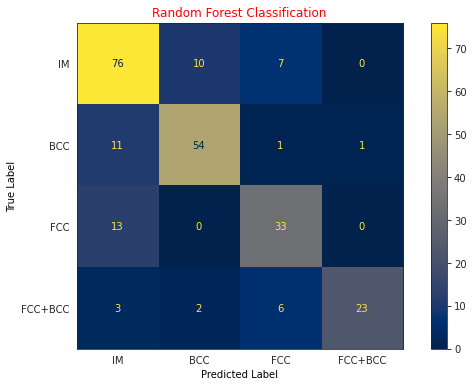

In [96]:
from sklearn.metrics import plot_confusion_matrix
class_names = ['IM', 'BCC', 'FCC', 'FCC+BCC']
cmplot= plot_confusion_matrix(model_rf_hyperkn, X_test_fullkn_rf, y_test_fullkn_rf, display_labels= class_names, cmap='cividis')
cmplot.ax_.set_title('Random Forest Classification', color='red')
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(color='black')
plt.gcf().axes[1].tick_params(color='black')
plt.gcf().set_size_inches(10,6)
plt.savefig('RFC_Confused_1.png', format='png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

In [51]:
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()

# for i in range(3):
#     fpr[i], tpr[i], _ = roc_curve(y_test_fullkn, probs_rf_hyper[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Plot ROC curves for each class
# plt.figure()
# colors = ['blue', 'red', 'green']
# for i in range(3):
#     plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
#              label=f'Class {i} (area = {roc_auc[i]:.2f})')

# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Multiclass (OvR)')
# plt.legend(loc="lower right")
# plt.show()

In [52]:

# fpr, tpr, thresholds = roc_curve(y_test_fullkn, probs_rf_hyper)
# roc_auc = auc(fpr, tpr)


## Hyper-parameter tuning for DecisionTreeClassifier

In [127]:
from scipy.sparse.construct import random
import optuna
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    param = {
        "criterion": trial.suggest_categorical('criterion', ["gini", "entropy"]),
        "splitter": trial.suggest_categorical('splitter', ["best", "random"]),
        "max_depth": trial.suggest_int('max_depth', 2, 32, log=True),
        "min_samples_split": trial.suggest_int('min_samples_split', 2, 10, log=True),
        'random_state': trial.suggest_categorical('random_state', [0, 25, 100, None]),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1,10)
    }

    suggested_random_state = param['random_state']  # also use the suggested random state value in train_test_split()
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.2, shuffle=True, random_state=suggested_random_state)
    clf = DecisionTreeClassifier()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average='weighted') # Calculate F1-score #average='weighted'
    precision = precision_score(y_pred, y_test, average='weighted') # Calculate Precision
    recall = recall_score(y_pred, y_test, average='weighted')  # Calculate Recall
    print(f"Model Accuracy: {round(acc, 6)}")
    print(f"Model F1-score: {round(f1, 6)}")
    print(f"Model precision-score: {round(precision, 6)}")
    print(f"Model recall-score: {round(recall, 6)}")

    print(f"Model Parameters: {param}")
    
    return acc  # return our objective value
    return f1
    return precision
    return recall

if __name__ == "__main__":
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler()
    )
    study.optimize(objective, n_trials=50)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-06-10 10:00:17,613] A new study created in memory with name: no-name-8b8a7616-487f-4eff-97e6-c3474ae014bd
[I 2024-06-10 10:00:17,654] Trial 0 finished with value: 0.7375 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 10, 'random_state': 0, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7375.
[I 2024-06-10 10:00:17,694] Trial 1 finished with value: 0.75 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 3, 'random_state': 100, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.75.
[I 2024-06-10 10:00:17,736] Trial 2 finished with value: 0.7125 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 2, 'random_state': None, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.75.
[I 2024-06-10 10:00:17,774] Trial 3 finished with value: 0.7125 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples

Model Accuracy: 0.7375
Model F1-score: 0.737735
Model precision-score: 0.746228
Model recall-score: 0.7375
Model Parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 10, 'random_state': 0, 'min_samples_leaf': 10}
Model Accuracy: 0.75
Model F1-score: 0.747542
Model precision-score: 0.754651
Model recall-score: 0.75
Model Parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 12, 'min_samples_split': 3, 'random_state': 100, 'min_samples_leaf': 8}
Model Accuracy: 0.7125
Model F1-score: 0.713831
Model precision-score: 0.71605
Model recall-score: 0.7125
Model Parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 4, 'min_samples_split': 2, 'random_state': None, 'min_samples_leaf': 3}
Model Accuracy: 0.7125
Model F1-score: 0.714872
Model precision-score: 0.71905
Model recall-score: 0.7125
Model Parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 10, 'random_state': None, 'min_sampl

[I 2024-06-10 10:00:17,881] Trial 6 finished with value: 0.7541666666666667 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 3, 'random_state': 100, 'min_samples_leaf': 3}. Best is trial 6 with value: 0.7541666666666667.
[I 2024-06-10 10:00:17,908] Trial 7 finished with value: 0.7375 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 8, 'random_state': 100, 'min_samples_leaf': 9}. Best is trial 6 with value: 0.7541666666666667.
[I 2024-06-10 10:00:17,925] Trial 8 finished with value: 0.7375 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 30, 'min_samples_split': 8, 'random_state': None, 'min_samples_leaf': 2}. Best is trial 6 with value: 0.7541666666666667.
[I 2024-06-10 10:00:17,943] Trial 9 finished with value: 0.7416666666666667 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 4, 'random_state': 0, 'min_samples_l

Model Accuracy: 0.754167
Model F1-score: 0.75181
Model precision-score: 0.757419
Model recall-score: 0.754167
Model Parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10, 'min_samples_split': 3, 'random_state': 100, 'min_samples_leaf': 3}
Model Accuracy: 0.7375
Model F1-score: 0.734681
Model precision-score: 0.738621
Model recall-score: 0.7375
Model Parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 8, 'random_state': 100, 'min_samples_leaf': 9}
Model Accuracy: 0.7375
Model F1-score: 0.737249
Model precision-score: 0.74878
Model recall-score: 0.7375
Model Parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 30, 'min_samples_split': 8, 'random_state': None, 'min_samples_leaf': 2}
Model Accuracy: 0.741667
Model F1-score: 0.743268
Model precision-score: 0.752384
Model recall-score: 0.741667
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 4, 'random_state': 0,

[I 2024-06-10 10:00:18,109] Trial 15 finished with value: 0.6916666666666667 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 6, 'random_state': 25, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.7583333333333333.
[I 2024-06-10 10:00:18,135] Trial 16 finished with value: 0.75 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 5, 'random_state': 100, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.7583333333333333.
[I 2024-06-10 10:00:18,163] Trial 17 finished with value: 0.7416666666666667 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 4, 'random_state': 100, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.7583333333333333.
[I 2024-06-10 10:00:18,190] Trial 18 finished with value: 0.7583333333333333 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 6, 'random_state': 100, 'min_sa

Model Accuracy: 0.691667
Model F1-score: 0.692317
Model precision-score: 0.697166
Model recall-score: 0.691667
Model Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 18, 'min_samples_split': 6, 'random_state': 25, 'min_samples_leaf': 7}
Model Accuracy: 0.75
Model F1-score: 0.749086
Model precision-score: 0.758324
Model recall-score: 0.75
Model Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'min_samples_split': 5, 'random_state': 100, 'min_samples_leaf': 4}
Model Accuracy: 0.741667
Model F1-score: 0.740021
Model precision-score: 0.750279
Model recall-score: 0.741667
Model Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 4, 'random_state': 100, 'min_samples_leaf': 7}
Model Accuracy: 0.758333
Model F1-score: 0.756432
Model precision-score: 0.757887
Model recall-score: 0.758333
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 6, 'random_state': 100, 'min_sa

[I 2024-06-10 10:00:18,330] Trial 23 finished with value: 0.7625 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 7, 'random_state': 100, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:18,358] Trial 24 finished with value: 0.7541666666666667 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 7, 'random_state': 100, 'min_samples_leaf': 6}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:18,386] Trial 25 finished with value: 0.7541666666666667 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 7, 'random_state': 100, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:18,414] Trial 26 finished with value: 0.75 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 4, 'random_state': 100, 'min_samples_leaf': 8}. Best is trial 21 with v

Model Accuracy: 0.7625
Model F1-score: 0.760698
Model precision-score: 0.766964
Model recall-score: 0.7625
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 7, 'random_state': 100, 'min_samples_leaf': 5}
Model Accuracy: 0.754167
Model F1-score: 0.752353
Model precision-score: 0.755955
Model recall-score: 0.754167
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 7, 'random_state': 100, 'min_samples_leaf': 6}
Model Accuracy: 0.754167
Model F1-score: 0.752422
Model precision-score: 0.757963
Model recall-score: 0.754167
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 3, 'min_samples_split': 7, 'random_state': 100, 'min_samples_leaf': 5}
Model Accuracy: 0.75
Model F1-score: 0.750554
Model precision-score: 0.759491
Model recall-score: 0.75
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 4, 'random_state': 100, 'mi

[I 2024-06-10 10:00:18,558] Trial 31 finished with value: 0.75 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 6, 'random_state': 100, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:18,586] Trial 32 finished with value: 0.7416666666666667 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 6, 'random_state': 100, 'min_samples_leaf': 4}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:18,614] Trial 33 finished with value: 0.7541666666666667 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 7, 'random_state': 100, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:18,642] Trial 34 finished with value: 0.7625 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 10, 'random_state': 100, 'min_samples_leaf': 2}. Best is trial 21 with

Model Accuracy: 0.75
Model F1-score: 0.749304
Model precision-score: 0.755654
Model recall-score: 0.75
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 6, 'random_state': 100, 'min_samples_leaf': 4}
Model Accuracy: 0.741667
Model F1-score: 0.739231
Model precision-score: 0.744136
Model recall-score: 0.741667
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 8, 'min_samples_split': 6, 'random_state': 100, 'min_samples_leaf': 4}
Model Accuracy: 0.754167
Model F1-score: 0.752366
Model precision-score: 0.756566
Model recall-score: 0.754167
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 6, 'min_samples_split': 7, 'random_state': 100, 'min_samples_leaf': 3}
Model Accuracy: 0.7625
Model F1-score: 0.761088
Model precision-score: 0.765503
Model recall-score: 0.7625
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 10, 'random_state': 100, '

[I 2024-06-10 10:00:18,786] Trial 39 finished with value: 0.7291666666666666 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 22, 'min_samples_split': 10, 'random_state': 0, 'min_samples_leaf': 7}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:18,816] Trial 40 finished with value: 0.7541666666666667 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 8, 'random_state': 100, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:18,845] Trial 41 finished with value: 0.7541666666666667 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 7, 'random_state': 100, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:18,873] Trial 42 finished with value: 0.7333333333333333 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 5, 'random_state': 100, 'min_samples_leaf': 3}.

Model Accuracy: 0.729167
Model F1-score: 0.734014
Model precision-score: 0.748796
Model recall-score: 0.729167
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 22, 'min_samples_split': 10, 'random_state': 0, 'min_samples_leaf': 7}
Model Accuracy: 0.754167
Model F1-score: 0.75278
Model precision-score: 0.758561
Model recall-score: 0.754167
Model Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 8, 'random_state': 100, 'min_samples_leaf': 3}
Model Accuracy: 0.754167
Model F1-score: 0.752548
Model precision-score: 0.756385
Model recall-score: 0.754167
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 9, 'min_samples_split': 7, 'random_state': 100, 'min_samples_leaf': 5}
Model Accuracy: 0.733333
Model F1-score: 0.731025
Model precision-score: 0.740958
Model recall-score: 0.733333
Model Parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 5, 'random_state':

[I 2024-06-10 10:00:18,990] Trial 46 finished with value: 0.75 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 10, 'random_state': 100, 'min_samples_leaf': 10}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:19,019] Trial 47 finished with value: 0.6958333333333333 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 28, 'min_samples_split': 2, 'random_state': 25, 'min_samples_leaf': 8}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:19,048] Trial 48 finished with value: 0.7708333333333334 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 8, 'random_state': 100, 'min_samples_leaf': 5}. Best is trial 21 with value: 0.7875.
[I 2024-06-10 10:00:19,077] Trial 49 finished with value: 0.75 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 8, 'random_state': 100, 'min_samples_leaf': 5}. Best is trial 21 with value:

Model Accuracy: 0.75
Model F1-score: 0.748839
Model precision-score: 0.756808
Model recall-score: 0.75
Model Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 4, 'min_samples_split': 10, 'random_state': 100, 'min_samples_leaf': 10}
Model Accuracy: 0.695833
Model F1-score: 0.696039
Model precision-score: 0.705669
Model recall-score: 0.695833
Model Parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 28, 'min_samples_split': 2, 'random_state': 25, 'min_samples_leaf': 8}
Model Accuracy: 0.770833
Model F1-score: 0.76816
Model precision-score: 0.776217
Model recall-score: 0.770833
Model Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 10, 'min_samples_split': 8, 'random_state': 100, 'min_samples_leaf': 5}
Model Accuracy: 0.75
Model F1-score: 0.748265
Model precision-score: 0.762355
Model recall-score: 0.75
Model Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 12, 'min_samples_split': 8, 'random_state': 100, 'min_sample

## ROC and AUC for DecisionTreeClassifier

In [128]:
knn_pipeline2= Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),('RobustScaler', RobustScaler())])
X_knn2 =knn_pipeline2.fit_transform(X_full)
X_train_fullkn_dt, X_test_fullkn_dt, y_train_fullkn_dt, y_test_fullkn_dt = train_test_split(X_knn2, y_full, test_size=0.20, random_state=42)

## Hyper-tuned DTC
best_params = trial.params
model_dtc_hyperkn = DecisionTreeClassifier(**best_params).fit(X_train_fullkn_dt, y_train_fullkn_dt)
probs_dtc_hyper = model_dtc_hyperkn.predict_proba(X_test_fullkn_dt)#[:, 1]

auc_dtc = roc_auc_score(y_test_fullkn_dt, probs_dtc_hyper, multi_class='ovr')
print('AUC of DTC: {:.4f}'.format(auc_dtc))


DTC_KNN = DecisionTreeClassifier() #random_state= 100, min_samples_split= 6,

scores_cv_dtc = cross_val_score(DTC_KNN, X_knn2, y_full, cv=10, scoring='roc_auc_ovr')
    
scores_cv_dtc_mean= scores_cv_dtc.mean()
scores_cv_dtc_std= scores_cv_dtc.std()
#print('10-fold CV of RFC', (scores_cv_rf))
print('10-fold CV mean of XGB: {:.4f}'.format(scores_cv_dtc_mean))
print('10-fold CV std of XGB: {:.4f}'.format(scores_cv_dtc_std))

AUC of DTC: 0.8256
10-fold CV mean of XGB: 0.7649
10-fold CV std of XGB: 0.0521


### Confusion Matrix for DecisionTreeClassifier

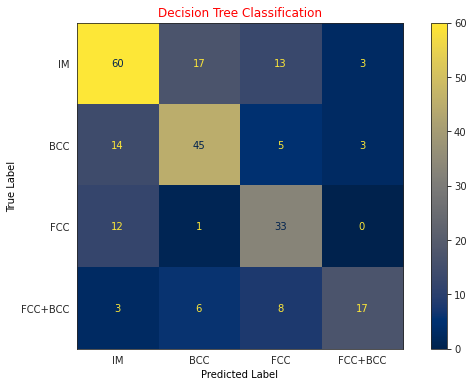

In [95]:
from sklearn.metrics import plot_confusion_matrix
class_names = ['IM', 'BCC', 'FCC', 'FCC+BCC']
cmplot= plot_confusion_matrix(model_dtc_hyperkn, X_test_fullkn_dt, y_test_fullkn_dt, display_labels= class_names, cmap='cividis')
cmplot.ax_.set_title('Decision Tree Classification', color='red')
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(color='black')
plt.gcf().axes[1].tick_params(color='black')
plt.gcf().set_size_inches(10,6)
plt.savefig('DTC_Confused_1.png', format='png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

## Hyper-parameter tuning for KNeighborsClassifier

In [56]:
from scipy.sparse.construct import random
import optuna
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 25),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev', 'cosine'])
    }

    suggested_random_state = trial.suggest_categorical('random_state', [0, 25, 100, None]) 
    
    X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.2, shuffle=True, random_state=suggested_random_state)
    clf = KNeighborsClassifier(**param)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average='weighted') # Calculate F1-score #average='weighted'
    precision = precision_score(y_pred, y_test, average='weighted') # Calculate Precision
    recall = recall_score(y_pred, y_test, average='weighted')  # Calculate Recall
    print(f"Model Accuracy: {round(acc, 6)}")
    print(f"Model F1-score: {round(f1, 6)}")
    print(f"Model precision-score: {round(precision, 6)}")
    print(f"Model recall-score: {round(recall, 6)}")

    print(f"Model Parameters: {param}")
    
    return acc  # return our objective value
    return f1
    return precision
    return recall

if __name__ == "__main__":
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler()
    )
    study.optimize(objective, n_trials=50)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-06-10 08:38:09,879] A new study created in memory with name: no-name-fb47220f-863c-4416-a611-5027e6f1a83c
[I 2024-06-10 08:38:09,907] Trial 0 finished with value: 0.625 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'chebyshev', 'random_state': 25}. Best is trial 0 with value: 0.625.
[I 2024-06-10 08:38:09,938] Trial 1 finished with value: 0.6708333333333333 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'manhattan', 'random_state': 0}. Best is trial 1 with value: 0.6708333333333333.
[I 2024-06-10 08:38:09,964] Trial 2 finished with value: 0.65 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'cosine', 'random_state': 0}. Best is trial 1 with value: 0.6708333333333333.
[I 2024-06-10 08:38:10,073] Trial 3 finished with value: 0.6791666666666667 and parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'chebyshev', 'random_state': None}. Best is trial 3 with value: 0.6791666666666667.
[I 2024-06-10 08:38:10,

Model Accuracy: 0.625
Model F1-score: 0.627819
Model precision-score: 0.643486
Model recall-score: 0.625
Model Parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'chebyshev'}
Model Accuracy: 0.670833
Model F1-score: 0.671103
Model precision-score: 0.67279
Model recall-score: 0.670833
Model Parameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'manhattan'}
Model Accuracy: 0.65
Model F1-score: 0.649443
Model precision-score: 0.655562
Model recall-score: 0.65
Model Parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'cosine'}
Model Accuracy: 0.679167
Model F1-score: 0.679458
Model precision-score: 0.681486
Model recall-score: 0.679167
Model Parameters: {'n_neighbors': 16, 'weights': 'distance', 'metric': 'chebyshev'}
Model Accuracy: 0.533333
Model F1-score: 0.532634
Model precision-score: 0.53739
Model recall-score: 0.533333
Model Parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'chebyshev'}


[I 2024-06-10 08:38:10,124] Trial 5 finished with value: 0.7416666666666667 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'random_state': 0}. Best is trial 5 with value: 0.7416666666666667.
[I 2024-06-10 08:38:10,148] Trial 6 finished with value: 0.5083333333333333 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'chebyshev', 'random_state': 0}. Best is trial 5 with value: 0.7416666666666667.
[I 2024-06-10 08:38:10,169] Trial 7 finished with value: 0.7041666666666667 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'random_state': 100}. Best is trial 5 with value: 0.7416666666666667.
[I 2024-06-10 08:38:10,180] Trial 8 finished with value: 0.7083333333333334 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'euclidean', 'random_state': 0}. Best is trial 5 with value: 0.7416666666666667.
[I 2024-06-10 08:38:10,266] Trial 9 finished with value: 0.6333333333333333 and parameters: {'n_neigh

Model Accuracy: 0.741667
Model F1-score: 0.743428
Model precision-score: 0.748
Model recall-score: 0.741667
Model Parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan'}
Model Accuracy: 0.508333
Model F1-score: 0.506754
Model precision-score: 0.511905
Model recall-score: 0.508333
Model Parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'chebyshev'}
Model Accuracy: 0.704167
Model F1-score: 0.709705
Model precision-score: 0.726251
Model recall-score: 0.704167
Model Parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}
Model Accuracy: 0.708333
Model F1-score: 0.710355
Model precision-score: 0.728834
Model recall-score: 0.708333
Model Parameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'euclidean'}
Model Accuracy: 0.633333
Model F1-score: 0.634386
Model precision-score: 0.639348
Model recall-score: 0.633333
Model Parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'manhattan'}


[I 2024-06-10 08:38:10,365] Trial 10 finished with value: 0.7166666666666667 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'cosine', 'random_state': 25}. Best is trial 5 with value: 0.7416666666666667.
[I 2024-06-10 08:38:10,467] Trial 11 finished with value: 0.7166666666666667 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'cosine', 'random_state': 25}. Best is trial 5 with value: 0.7416666666666667.


Model Accuracy: 0.716667
Model F1-score: 0.717168
Model precision-score: 0.720495
Model recall-score: 0.716667
Model Parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'cosine'}
Model Accuracy: 0.716667
Model F1-score: 0.716859
Model precision-score: 0.722589
Model recall-score: 0.716667
Model Parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'cosine'}


[I 2024-06-10 08:38:10,569] Trial 12 finished with value: 0.7166666666666667 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'cosine', 'random_state': 25}. Best is trial 5 with value: 0.7416666666666667.


Model Accuracy: 0.716667
Model F1-score: 0.718128
Model precision-score: 0.724301
Model recall-score: 0.716667
Model Parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'cosine'}
Model Accuracy: 0.695833

[I 2024-06-10 08:38:10,770] Trial 13 finished with value: 0.6958333333333333 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'random_state': None}. Best is trial 5 with value: 0.7416666666666667.
[I 2024-06-10 08:38:10,879] Trial 14 finished with value: 0.7708333333333334 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 25}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:10,901] Trial 15 finished with value: 0.75 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 25}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:10,924] Trial 16 finished with value: 0.7541666666666667 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 25}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:10,944] Trial 17 finished with value: 0.725 and parameters: {'n_neighbors': 10, 


Model F1-score: 0.697876
Model precision-score: 0.705315
Model recall-score: 0.695833
Model Parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}
Model Accuracy: 0.770833
Model F1-score: 0.770254
Model precision-score: 0.771051
Model recall-score: 0.770833
Model Parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.75
Model F1-score: 0.751739
Model precision-score: 0.757206
Model recall-score: 0.75
Model Parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.754167
Model F1-score: 0.755063
Model precision-score: 0.759612
Model recall-score: 0.754167
Model Parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.725
Model F1-score: 0.725439
Model precision-score: 0.730869
Model recall-score: 0.725
Model Parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.691667
Model F1-score: 0.689155
Model precision-

[I 2024-06-10 08:38:10,987] Trial 19 finished with value: 0.7375 and parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 25}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:11,001] Trial 20 finished with value: 0.7541666666666667 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:11,068] Trial 21 finished with value: 0.7541666666666667 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:11,168] Trial 22 finished with value: 0.7291666666666666 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.


Model Accuracy: 0.7375
Model F1-score: 0.738046
Model precision-score: 0.742725
Model recall-score: 0.7375
Model Parameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.754167
Model F1-score: 0.753997
Model precision-score: 0.759928
Model recall-score: 0.754167
Model Parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}
Model Accuracy: 0.754167
Model F1-score: 0.753997
Model precision-score: 0.759928
Model recall-score: 0.754167
Model Parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'euclidean'}
Model Accuracy: 0.729167
Model F1-score: 0.729207
Model precision-score: 0.732183
Model recall-score: 0.729167
Model Parameters: {'n_neighbors': 9, 'weights': 'distance', 'metric': 'euclidean'}


[I 2024-06-10 08:38:11,271] Trial 23 finished with value: 0.7625 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:11,373] Trial 24 finished with value: 0.7125 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'euclidean', 'random_state': None}. Best is trial 14 with value: 0.7708333333333334.


Model Accuracy: 0.7625
Model F1-score: 0.762121
Model precision-score: 0.764645
Model recall-score: 0.7625
Model Parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}
Model Accuracy: 0.7125
Model F1-score: 0.71211
Model precision-score: 0.712794
Model recall-score: 0.7125
Model Parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'euclidean'}


[I 2024-06-10 08:38:11,562] Trial 25 finished with value: 0.7625 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:11,575] Trial 26 finished with value: 0.7625 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:11,589] Trial 27 finished with value: 0.7625 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:11,669] Trial 28 finished with value: 0.7625 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.


Model Accuracy: 0.7625
Model F1-score: 0.763704
Model precision-score: 0.769434
Model recall-score: 0.7625
Model Parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.7625
Model F1-score: 0.763704
Model precision-score: 0.769434
Model recall-score: 0.7625
Model Parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.7625
Model F1-score: 0.763089
Model precision-score: 0.767042
Model recall-score: 0.7625
Model Parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}
Model Accuracy: 0.7625
Model F1-score: 0.763704
Model precision-score: 0.769434
Model recall-score: 0.7625
Model Parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}


[I 2024-06-10 08:38:11,774] Trial 29 finished with value: 0.7208333333333333 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'chebyshev', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:11,789] Trial 30 finished with value: 0.7625 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:11,869] Trial 31 finished with value: 0.7625 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.


Model Accuracy: 0.720833
Model F1-score: 0.720016
Model precision-score: 0.722511
Model recall-score: 0.720833
Model Parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'chebyshev'}
Model Accuracy: 0.7625
Model F1-score: 0.763089
Model precision-score: 0.767042
Model recall-score: 0.7625
Model Parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'}
Model Accuracy: 0.7625
Model F1-score: 0.763704
Model precision-score: 0.769434
Model recall-score: 0.7625
Model Parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}


[I 2024-06-10 08:38:11,975] Trial 32 finished with value: 0.7458333333333333 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:11,989] Trial 33 finished with value: 0.7625 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:12,004] Trial 34 finished with value: 0.7458333333333333 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 100}. Best is trial 14 with value: 0.7708333333333334.
[I 2024-06-10 08:38:12,018] Trial 35 finished with value: 0.7875 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan', 'random_state': None}. Best is trial 35 with value: 0.7875.
[I 2024-06-10 08:38:12,033] Trial 36 finished with value: 0.6875 and parameters: {'n_neighbors': 15, 'weights': 'distan

Model Accuracy: 0.745833
Model F1-score: 0.745921
Model precision-score: 0.753207
Model recall-score: 0.745833
Model Parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.7625
Model F1-score: 0.763704
Model precision-score: 0.769434
Model recall-score: 0.7625
Model Parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.745833
Model F1-score: 0.745921
Model precision-score: 0.753207
Model recall-score: 0.745833
Model Parameters: {'n_neighbors': 3, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.7875
Model F1-score: 0.789071
Model precision-score: 0.806119
Model recall-score: 0.7875
Model Parameters: {'n_neighbors': 6, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.6875
Model F1-score: 0.687634
Model precision-score: 0.690364
Model recall-score: 0.6875
Model Parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'chebyshev'}
Model Accuracy: 0.733333
Model F1-score: 

[I 2024-06-10 08:38:12,185] Trial 40 finished with value: 0.575 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'chebyshev', 'random_state': 0}. Best is trial 35 with value: 0.7875.
[I 2024-06-10 08:38:12,201] Trial 41 finished with value: 0.7625 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 100}. Best is trial 35 with value: 0.7875.
[I 2024-06-10 08:38:12,215] Trial 42 finished with value: 0.7541666666666667 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'random_state': None}. Best is trial 35 with value: 0.7875.
[I 2024-06-10 08:38:12,231] Trial 43 finished with value: 0.7291666666666666 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 100}. Best is trial 35 with value: 0.7875.
[I 2024-06-10 08:38:12,246] Trial 44 finished with value: 0.8 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan', 'random_state':

Model Accuracy: 0.575
Model F1-score: 0.575639
Model precision-score: 0.584238
Model recall-score: 0.575
Model Parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'chebyshev'}
Model Accuracy: 0.7625
Model F1-score: 0.763704
Model precision-score: 0.769434
Model recall-score: 0.7625
Model Parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.754167
Model F1-score: 0.754326
Model precision-score: 0.754998
Model recall-score: 0.754167
Model Parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.729167
Model F1-score: 0.730475
Model precision-score: 0.736508
Model recall-score: 0.729167
Model Parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.8
Model F1-score: 0.799361
Model precision-score: 0.802621
Model recall-score: 0.8
Model Parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}
Model Accuracy: 0.741667
Model F1-score: 0.743428


[I 2024-06-10 08:38:12,481] Trial 48 finished with value: 0.6916666666666667 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'euclidean', 'random_state': 0}. Best is trial 44 with value: 0.8.
[I 2024-06-10 08:38:12,664] Trial 49 finished with value: 0.8 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan', 'random_state': 0}. Best is trial 44 with value: 0.8.


Model Accuracy: 0.691667
Model F1-score: 0.688625
Model precision-score: 0.692693
Model recall-score: 0.691667
Model Parameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'euclidean'}
Model Accuracy: 0.8
Model F1-score: 0.799361
Model precision-score: 0.802621
Model recall-score: 0.8
Model Parameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'manhattan'}
Number of finished trials: 50
Best trial:
  Value: 0.8
  Params: 
    n_neighbors: 2
    weights: distance
    metric: manhattan
    random_state: 0


## ROC and AUC for KNeighborsClassifier

In [57]:
params_less = trial.params
del params_less['random_state']

In [129]:
knn_pipeline2= Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),('RobustScaler', RobustScaler())])
X_knn2 =knn_pipeline2.fit_transform(X_full)
X_train_fullkn_kn, X_test_fullkn_kn, y_train_fullkn_kn, y_test_fullkn_kn = train_test_split(X_knn2, y_full, test_size=0.20, random_state=42)

## Hyper-tuned KNC
# remove the random_state parameter from trial.params:
best_params_kn = params_less
model_knc_hyperkn = KNeighborsClassifier(**best_params_kn).fit(X_train_fullkn_kn, y_train_fullkn_kn)
probs_knc_hyper = model_knc_hyperkn .predict_proba(X_test_fullkn_kn)#[:, 1]

auc_knc = roc_auc_score(y_test_fullkn_kn, probs_knc_hyper, multi_class='ovr')
print('AUC of KNC: {:.4f}'.format(auc_knc))


KNC_KNN = KNeighborsClassifier() #random_state= 100, min_samples_split= 6,

scores_cv_knc = cross_val_score(KNC_KNN, X_knn2, y_full, cv=10, scoring='roc_auc_ovr')
    
scores_cv_knc_mean= scores_cv_knc.mean()
scores_cv_knc_std= scores_cv_knc.std()
#print('10-fold CV of RFC', (scores_cv_rf))
print('10-fold CV mean of KNC: {:.4f}'.format(scores_cv_knc_mean))
print('10-fold CV std of KNC: {:.4f}'.format(scores_cv_knc_std))

AUC of KNC: 0.8788
10-fold CV mean of KNC: 0.8315
10-fold CV std of KNC: 0.0446


### Confusion Matrix for KNeighborsClassifier

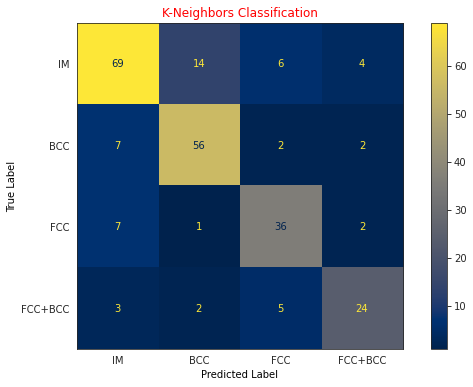

In [94]:
from sklearn.metrics import plot_confusion_matrix
class_names = ['IM', 'BCC', 'FCC', 'FCC+BCC']
cmplot= plot_confusion_matrix(model_knc_hyperkn, X_test_fullkn_kn, y_test_fullkn_kn, display_labels= class_names, cmap='cividis')
cmplot.ax_.set_title('K-Neighbors Classification', color='red')
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(color='black')
plt.gcf().axes[1].tick_params(color='black')
plt.gcf().set_size_inches(10,6)
plt.savefig('KNC_Confused_1.png', format='png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

## Hyper-parameter tuning for XGBoost

In [122]:
from scipy.sparse.construct import random
import optuna
from sklearn.ensemble import RandomForestClassifier

def objective(trial):
    param = {
        'random_state': trial.suggest_categorical('random_state', [0, 25, 100, None]),
       " criterion" : trial.suggest_int('min_samples_split', 1,10),
        "max_depth" : trial.suggest_int("max_depth", 2, 32, log=True),
        "n_estimators" : trial.suggest_int("n_estimators", 100,1000),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1,10)
        # 'bootstrap': trial.suggest_categorical('bootstrap' , [True, False]),
        # 'max_features': trial.suggest_categorical("max_features" , ['auto', 'sqrt'])
    }

    suggested_random_state = param['random_state']  # also use the suggested random state value in train_test_split()
    
    
    X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.2, shuffle=True, random_state=suggested_random_state)
    clf = XGBClassifier()

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average='weighted') # Calculate F1-score #average='weighted'
    precision = precision_score(y_pred, y_test, average='weighted') # Calculate Precision
    recall = recall_score(y_pred, y_test, average='weighted')  # Calculate Recall
    print(f"Model Accuracy: {round(acc, 6)}")
    print(f"Model F1-score: {round(f1, 6)}")
    print(f"Model precision-score: {round(precision, 6)}")
    print(f"Model recall-score: {round(recall, 6)}")

    print(f"Model Parameters: {param}")
    
    return acc  # return our objective value
    return f1
    return precision
    return recall

if __name__ == "__main__":
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler()
    )
    study.optimize(objective, n_trials=50)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-06-10 09:47:04,426] A new study created in memory with name: no-name-153cc2fb-e750-41a5-887f-f799b6564177
[I 2024-06-10 09:47:04,795] Trial 0 finished with value: 0.8208333333333333 and parameters: {'random_state': 0, 'min_samples_split': 9, 'max_depth': 16, 'n_estimators': 571, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8208333333333333.


Model Accuracy: 0.820833
Model F1-score: 0.819597
Model precision-score: 0.824121
Model recall-score: 0.820833
Model Parameters: {'random_state': 0, ' criterion': 9, 'max_depth': 16, 'n_estimators': 571, 'min_samples_leaf': 9}


[I 2024-06-10 09:47:05,052] Trial 1 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 9, 'max_depth': 4, 'n_estimators': 639, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 9, 'max_depth': 4, 'n_estimators': 639, 'min_samples_leaf': 9}


[I 2024-06-10 09:47:05,310] Trial 2 finished with value: 0.7875 and parameters: {'random_state': None, 'min_samples_split': 4, 'max_depth': 14, 'n_estimators': 989, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.7875
Model F1-score: 0.788625
Model precision-score: 0.791216
Model recall-score: 0.7875
Model Parameters: {'random_state': None, ' criterion': 4, 'max_depth': 14, 'n_estimators': 989, 'min_samples_leaf': 4}


[I 2024-06-10 09:47:05,567] Trial 3 finished with value: 0.8208333333333333 and parameters: {'random_state': 0, 'min_samples_split': 10, 'max_depth': 4, 'n_estimators': 986, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.820833
Model F1-score: 0.819597
Model precision-score: 0.824121
Model recall-score: 0.820833
Model Parameters: {'random_state': 0, ' criterion': 10, 'max_depth': 4, 'n_estimators': 986, 'min_samples_leaf': 4}


[I 2024-06-10 09:47:05,818] Trial 4 finished with value: 0.8041666666666667 and parameters: {'random_state': 25, 'min_samples_split': 7, 'max_depth': 24, 'n_estimators': 358, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.804167
Model F1-score: 0.804003
Model precision-score: 0.807047
Model recall-score: 0.804167
Model Parameters: {'random_state': 25, ' criterion': 7, 'max_depth': 24, 'n_estimators': 358, 'min_samples_leaf': 4}


[I 2024-06-10 09:47:06,071] Trial 5 finished with value: 0.8041666666666667 and parameters: {'random_state': 25, 'min_samples_split': 10, 'max_depth': 2, 'n_estimators': 243, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.804167
Model F1-score: 0.804003
Model precision-score: 0.807047
Model recall-score: 0.804167
Model Parameters: {'random_state': 25, ' criterion': 10, 'max_depth': 2, 'n_estimators': 243, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:06,329] Trial 6 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 1, 'max_depth': 20, 'n_estimators': 781, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 1, 'max_depth': 20, 'n_estimators': 781, 'min_samples_leaf': 9}


[I 2024-06-10 09:47:06,591] Trial 7 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 7, 'max_depth': 32, 'n_estimators': 896, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 7, 'max_depth': 32, 'n_estimators': 896, 'min_samples_leaf': 2}


[I 2024-06-10 09:47:06,844] Trial 8 finished with value: 0.8208333333333333 and parameters: {'random_state': 0, 'min_samples_split': 2, 'max_depth': 5, 'n_estimators': 152, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.820833
Model F1-score: 0.819597
Model precision-score: 0.824121
Model recall-score: 0.820833
Model Parameters: {'random_state': 0, ' criterion': 2, 'max_depth': 5, 'n_estimators': 152, 'min_samples_leaf': 3}


[I 2024-06-10 09:47:07,101] Trial 9 finished with value: 0.8041666666666667 and parameters: {'random_state': 25, 'min_samples_split': 9, 'max_depth': 19, 'n_estimators': 367, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.804167
Model F1-score: 0.804003
Model precision-score: 0.807047
Model recall-score: 0.804167
Model Parameters: {'random_state': 25, ' criterion': 9, 'max_depth': 19, 'n_estimators': 367, 'min_samples_leaf': 6}


[I 2024-06-10 09:47:07,371] Trial 10 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 5, 'max_depth': 2, 'n_estimators': 639, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 5, 'max_depth': 2, 'n_estimators': 639, 'min_samples_leaf': 10}


[I 2024-06-10 09:47:07,640] Trial 11 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 1, 'max_depth': 9, 'n_estimators': 739, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 1, 'max_depth': 9, 'n_estimators': 739, 'min_samples_leaf': 8}


[I 2024-06-10 09:47:07,908] Trial 12 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 3, 'max_depth': 8, 'n_estimators': 746, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 3, 'max_depth': 8, 'n_estimators': 746, 'min_samples_leaf': 10}


[I 2024-06-10 09:47:08,178] Trial 13 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 7, 'max_depth': 4, 'n_estimators': 779, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.825.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 7, 'max_depth': 4, 'n_estimators': 779, 'min_samples_leaf': 8}


[I 2024-06-10 09:47:08,453] Trial 14 finished with value: 0.8291666666666667 and parameters: {'random_state': None, 'min_samples_split': 5, 'max_depth': 3, 'n_estimators': 515, 'min_samples_leaf': 6}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.829167
Model F1-score: 0.830095
Model precision-score: 0.836329
Model recall-score: 0.829167
Model Parameters: {'random_state': None, ' criterion': 5, 'max_depth': 3, 'n_estimators': 515, 'min_samples_leaf': 6}


[I 2024-06-10 09:47:08,723] Trial 15 finished with value: 0.8 and parameters: {'random_state': None, 'min_samples_split': 6, 'max_depth': 3, 'n_estimators': 481, 'min_samples_leaf': 6}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.8
Model F1-score: 0.799908
Model precision-score: 0.802151
Model recall-score: 0.8
Model Parameters: {'random_state': None, ' criterion': 6, 'max_depth': 3, 'n_estimators': 481, 'min_samples_leaf': 6}


[I 2024-06-10 09:47:08,996] Trial 16 finished with value: 0.8125 and parameters: {'random_state': None, 'min_samples_split': 5, 'max_depth': 3, 'n_estimators': 472, 'min_samples_leaf': 1}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.8125
Model F1-score: 0.811708
Model precision-score: 0.814498
Model recall-score: 0.8125
Model Parameters: {'random_state': None, ' criterion': 5, 'max_depth': 3, 'n_estimators': 472, 'min_samples_leaf': 1}


[I 2024-06-10 09:47:09,267] Trial 17 finished with value: 0.8208333333333333 and parameters: {'random_state': None, 'min_samples_split': 8, 'max_depth': 6, 'n_estimators': 630, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.820833
Model F1-score: 0.82155
Model precision-score: 0.83302
Model recall-score: 0.820833
Model Parameters: {'random_state': None, ' criterion': 8, 'max_depth': 6, 'n_estimators': 630, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:09,536] Trial 18 finished with value: 0.8291666666666667 and parameters: {'random_state': None, 'min_samples_split': 3, 'max_depth': 3, 'n_estimators': 372, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.829167
Model F1-score: 0.828485
Model precision-score: 0.833444
Model recall-score: 0.829167
Model Parameters: {'random_state': None, ' criterion': 3, 'max_depth': 3, 'n_estimators': 372, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:09,799] Trial 19 finished with value: 0.8083333333333333 and parameters: {'random_state': None, 'min_samples_split': 3, 'max_depth': 3, 'n_estimators': 360, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.808333
Model F1-score: 0.8079
Model precision-score: 0.808511
Model recall-score: 0.808333
Model Parameters: {'random_state': None, ' criterion': 3, 'max_depth': 3, 'n_estimators': 360, 'min_samples_leaf': 5}


[I 2024-06-10 09:47:10,065] Trial 20 finished with value: 0.825 and parameters: {'random_state': None, 'min_samples_split': 4, 'max_depth': 2, 'n_estimators': 243, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.825
Model F1-score: 0.824553
Model precision-score: 0.824757
Model recall-score: 0.825
Model Parameters: {'random_state': None, ' criterion': 4, 'max_depth': 2, 'n_estimators': 243, 'min_samples_leaf': 5}


[I 2024-06-10 09:47:10,340] Trial 21 finished with value: 0.8208333333333333 and parameters: {'random_state': None, 'min_samples_split': 4, 'max_depth': 4, 'n_estimators': 530, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.820833
Model F1-score: 0.819899
Model precision-score: 0.823378
Model recall-score: 0.820833
Model Parameters: {'random_state': None, ' criterion': 4, 'max_depth': 4, 'n_estimators': 530, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:10,611] Trial 22 finished with value: 0.7791666666666667 and parameters: {'random_state': None, 'min_samples_split': 6, 'max_depth': 3, 'n_estimators': 415, 'min_samples_leaf': 8}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.779167
Model F1-score: 0.782056
Model precision-score: 0.794321
Model recall-score: 0.779167
Model Parameters: {'random_state': None, ' criterion': 6, 'max_depth': 3, 'n_estimators': 415, 'min_samples_leaf': 8}


[I 2024-06-10 09:47:10,877] Trial 23 finished with value: 0.7791666666666667 and parameters: {'random_state': None, 'min_samples_split': 3, 'max_depth': 6, 'n_estimators': 634, 'min_samples_leaf': 9}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.779167
Model F1-score: 0.780542
Model precision-score: 0.786718
Model recall-score: 0.779167
Model Parameters: {'random_state': None, ' criterion': 3, 'max_depth': 6, 'n_estimators': 634, 'min_samples_leaf': 9}


[I 2024-06-10 09:47:11,144] Trial 24 finished with value: 0.8208333333333333 and parameters: {'random_state': None, 'min_samples_split': 2, 'max_depth': 5, 'n_estimators': 269, 'min_samples_leaf': 6}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.820833
Model F1-score: 0.821532
Model precision-score: 0.823414
Model recall-score: 0.820833
Model Parameters: {'random_state': None, ' criterion': 2, 'max_depth': 5, 'n_estimators': 269, 'min_samples_leaf': 6}


[I 2024-06-10 09:47:11,419] Trial 25 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 5, 'max_depth': 3, 'n_estimators': 563, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 5, 'max_depth': 3, 'n_estimators': 563, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:11,687] Trial 26 finished with value: 0.8041666666666667 and parameters: {'random_state': 25, 'min_samples_split': 8, 'max_depth': 2, 'n_estimators': 436, 'min_samples_leaf': 8}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.804167
Model F1-score: 0.804003
Model precision-score: 0.807047
Model recall-score: 0.804167
Model Parameters: {'random_state': 25, ' criterion': 8, 'max_depth': 2, 'n_estimators': 436, 'min_samples_leaf': 8}


[I 2024-06-10 09:47:11,955] Trial 27 finished with value: 0.8208333333333333 and parameters: {'random_state': 0, 'min_samples_split': 6, 'max_depth': 11, 'n_estimators': 672, 'min_samples_leaf': 9}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.820833
Model F1-score: 0.819597
Model precision-score: 0.824121
Model recall-score: 0.820833
Model Parameters: {'random_state': 0, ' criterion': 6, 'max_depth': 11, 'n_estimators': 672, 'min_samples_leaf': 9}


[I 2024-06-10 09:47:12,222] Trial 28 finished with value: 0.8208333333333333 and parameters: {'random_state': None, 'min_samples_split': 2, 'max_depth': 4, 'n_estimators': 295, 'min_samples_leaf': 5}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.820833
Model F1-score: 0.820424
Model precision-score: 0.822063
Model recall-score: 0.820833
Model Parameters: {'random_state': None, ' criterion': 2, 'max_depth': 4, 'n_estimators': 295, 'min_samples_leaf': 5}


[I 2024-06-10 09:47:12,497] Trial 29 finished with value: 0.8208333333333333 and parameters: {'random_state': 0, 'min_samples_split': 4, 'max_depth': 6, 'n_estimators': 118, 'min_samples_leaf': 10}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.820833
Model F1-score: 0.819597
Model precision-score: 0.824121
Model recall-score: 0.820833
Model Parameters: {'random_state': 0, ' criterion': 4, 'max_depth': 6, 'n_estimators': 118, 'min_samples_leaf': 10}


[I 2024-06-10 09:47:12,771] Trial 30 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 9, 'max_depth': 5, 'n_estimators': 528, 'min_samples_leaf': 6}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 9, 'max_depth': 5, 'n_estimators': 528, 'min_samples_leaf': 6}


[I 2024-06-10 09:47:13,050] Trial 31 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 1, 'max_depth': 14, 'n_estimators': 852, 'min_samples_leaf': 9}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 1, 'max_depth': 14, 'n_estimators': 852, 'min_samples_leaf': 9}


[I 2024-06-10 09:47:13,375] Trial 32 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 1, 'max_depth': 10, 'n_estimators': 827, 'min_samples_leaf': 9}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 1, 'max_depth': 10, 'n_estimators': 827, 'min_samples_leaf': 9}


[I 2024-06-10 09:47:13,647] Trial 33 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 2, 'max_depth': 19, 'n_estimators': 912, 'min_samples_leaf': 8}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 2, 'max_depth': 19, 'n_estimators': 912, 'min_samples_leaf': 8}


[I 2024-06-10 09:47:13,921] Trial 34 finished with value: 0.825 and parameters: {'random_state': 100, 'min_samples_split': 3, 'max_depth': 12, 'n_estimators': 702, 'min_samples_leaf': 9}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.825
Model F1-score: 0.824471
Model precision-score: 0.826369
Model recall-score: 0.825
Model Parameters: {'random_state': 100, ' criterion': 3, 'max_depth': 12, 'n_estimators': 702, 'min_samples_leaf': 9}


[I 2024-06-10 09:47:14,197] Trial 35 finished with value: 0.8291666666666667 and parameters: {'random_state': None, 'min_samples_split': 8, 'max_depth': 7, 'n_estimators': 589, 'min_samples_leaf': 7}. Best is trial 14 with value: 0.8291666666666667.


Model Accuracy: 0.829167
Model F1-score: 0.830046
Model precision-score: 0.831224
Model recall-score: 0.829167
Model Parameters: {'random_state': None, ' criterion': 8, 'max_depth': 7, 'n_estimators': 589, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:14,473] Trial 36 finished with value: 0.8458333333333333 and parameters: {'random_state': None, 'min_samples_split': 10, 'max_depth': 7, 'n_estimators': 597, 'min_samples_leaf': 7}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.845833
Model F1-score: 0.846251
Model precision-score: 0.848858
Model recall-score: 0.845833
Model Parameters: {'random_state': None, ' criterion': 10, 'max_depth': 7, 'n_estimators': 597, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:14,744] Trial 37 finished with value: 0.8083333333333333 and parameters: {'random_state': None, 'min_samples_split': 10, 'max_depth': 7, 'n_estimators': 596, 'min_samples_leaf': 7}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.808333
Model F1-score: 0.808041
Model precision-score: 0.808259
Model recall-score: 0.808333
Model Parameters: {'random_state': None, ' criterion': 10, 'max_depth': 7, 'n_estimators': 596, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:15,012] Trial 38 finished with value: 0.825 and parameters: {'random_state': None, 'min_samples_split': 8, 'max_depth': 7, 'n_estimators': 484, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.825
Model F1-score: 0.823655
Model precision-score: 0.825088
Model recall-score: 0.825
Model Parameters: {'random_state': None, ' criterion': 8, 'max_depth': 7, 'n_estimators': 484, 'min_samples_leaf': 4}


[I 2024-06-10 09:47:15,282] Trial 39 finished with value: 0.8 and parameters: {'random_state': None, 'min_samples_split': 10, 'max_depth': 8, 'n_estimators': 572, 'min_samples_leaf': 7}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.8
Model F1-score: 0.798715
Model precision-score: 0.800616
Model recall-score: 0.8
Model Parameters: {'random_state': None, ' criterion': 10, 'max_depth': 8, 'n_estimators': 572, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:15,558] Trial 40 finished with value: 0.7875 and parameters: {'random_state': None, 'min_samples_split': 8, 'max_depth': 5, 'n_estimators': 412, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.7875
Model F1-score: 0.787736
Model precision-score: 0.789794
Model recall-score: 0.7875
Model Parameters: {'random_state': None, ' criterion': 8, 'max_depth': 5, 'n_estimators': 412, 'min_samples_leaf': 6}


[I 2024-06-10 09:47:15,833] Trial 41 finished with value: 0.8125 and parameters: {'random_state': None, 'min_samples_split': 9, 'max_depth': 4, 'n_estimators': 682, 'min_samples_leaf': 5}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.8125
Model F1-score: 0.813109
Model precision-score: 0.81911
Model recall-score: 0.8125
Model Parameters: {'random_state': None, ' criterion': 9, 'max_depth': 4, 'n_estimators': 682, 'min_samples_leaf': 5}


[I 2024-06-10 09:47:16,102] Trial 42 finished with value: 0.8041666666666667 and parameters: {'random_state': 25, 'min_samples_split': 9, 'max_depth': 8, 'n_estimators': 520, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.804167
Model F1-score: 0.804003
Model precision-score: 0.807047
Model recall-score: 0.804167
Model Parameters: {'random_state': 25, ' criterion': 9, 'max_depth': 8, 'n_estimators': 520, 'min_samples_leaf': 8}


[I 2024-06-10 09:47:16,372] Trial 43 finished with value: 0.7666666666666667 and parameters: {'random_state': None, 'min_samples_split': 10, 'max_depth': 6, 'n_estimators': 603, 'min_samples_leaf': 7}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.766667
Model F1-score: 0.765818
Model precision-score: 0.770773
Model recall-score: 0.766667
Model Parameters: {'random_state': None, ' criterion': 10, 'max_depth': 6, 'n_estimators': 603, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:16,646] Trial 44 finished with value: 0.8208333333333333 and parameters: {'random_state': 0, 'min_samples_split': 7, 'max_depth': 4, 'n_estimators': 334, 'min_samples_leaf': 4}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.820833
Model F1-score: 0.819597
Model precision-score: 0.824121
Model recall-score: 0.820833
Model Parameters: {'random_state': 0, ' criterion': 7, 'max_depth': 4, 'n_estimators': 334, 'min_samples_leaf': 4}


[I 2024-06-10 09:47:16,917] Trial 45 finished with value: 0.7958333333333333 and parameters: {'random_state': None, 'min_samples_split': 10, 'max_depth': 10, 'n_estimators': 717, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.795833
Model F1-score: 0.798918
Model precision-score: 0.810307
Model recall-score: 0.795833
Model Parameters: {'random_state': None, ' criterion': 10, 'max_depth': 10, 'n_estimators': 717, 'min_samples_leaf': 6}


[I 2024-06-10 09:47:17,190] Trial 46 finished with value: 0.8041666666666667 and parameters: {'random_state': 25, 'min_samples_split': 9, 'max_depth': 5, 'n_estimators': 207, 'min_samples_leaf': 7}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.804167
Model F1-score: 0.804003
Model precision-score: 0.807047
Model recall-score: 0.804167
Model Parameters: {'random_state': 25, ' criterion': 9, 'max_depth': 5, 'n_estimators': 207, 'min_samples_leaf': 7}


[I 2024-06-10 09:47:17,465] Trial 47 finished with value: 0.8166666666666667 and parameters: {'random_state': None, 'min_samples_split': 9, 'max_depth': 9, 'n_estimators': 453, 'min_samples_leaf': 8}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.816667
Model F1-score: 0.815613
Model precision-score: 0.817064
Model recall-score: 0.816667
Model Parameters: {'random_state': None, ' criterion': 9, 'max_depth': 9, 'n_estimators': 453, 'min_samples_leaf': 8}


[I 2024-06-10 09:47:17,740] Trial 48 finished with value: 0.8083333333333333 and parameters: {'random_state': None, 'min_samples_split': 7, 'max_depth': 25, 'n_estimators': 657, 'min_samples_leaf': 6}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.808333
Model F1-score: 0.809103
Model precision-score: 0.812923
Model recall-score: 0.808333
Model Parameters: {'random_state': None, ' criterion': 7, 'max_depth': 25, 'n_estimators': 657, 'min_samples_leaf': 6}


[I 2024-06-10 09:47:18,010] Trial 49 finished with value: 0.7791666666666667 and parameters: {'random_state': None, 'min_samples_split': 5, 'max_depth': 14, 'n_estimators': 597, 'min_samples_leaf': 10}. Best is trial 36 with value: 0.8458333333333333.


Model Accuracy: 0.779167
Model F1-score: 0.7794
Model precision-score: 0.780985
Model recall-score: 0.779167
Model Parameters: {'random_state': None, ' criterion': 5, 'max_depth': 14, 'n_estimators': 597, 'min_samples_leaf': 10}
Number of finished trials: 50
Best trial:
  Value: 0.8458333333333333
  Params: 
    random_state: None
    min_samples_split: 10
    max_depth: 7
    n_estimators: 597
    min_samples_leaf: 7


## ROC and AUC for XGBoost

In [125]:
knn_pipeline2= Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),('RobustScaler', RobustScaler())])
X_knn2 =knn_pipeline2.fit_transform(X_full)
X_train_fullkn_xg, X_test_fullkn_xg, y_train_fullkn_xg, y_test_fullkn_xg = train_test_split(X_knn2, y_full, test_size=0.20, random_state=42)

## Hyper-tuned XGB
best_params = trial.params
model_xgb_hyperkn = XGBClassifier(**best_params).fit(X_train_fullkn_xg, y_train_fullkn_xg)
probs_xgb_hyper = model_xgb_hyperkn .predict_proba(X_test_fullkn_xg)#[:, 1]

auc_xgb = roc_auc_score(y_test_fullkn_xg, probs_xgb_hyper, multi_class='ovr')
print('AUC of XGB: {:.4f}'.format(auc_xgb))


XGB_KNN = XGBClassifier(**best_params) #random_state= 100, min_samples_split= 6,

scores_cv_xgb = cross_val_score(XGB_KNN, X_knn2, y_full, cv=10, scoring='roc_auc_ovr')
    
scores_cv_xgb_mean= scores_cv_xgb.mean()
scores_cv_xgb_std= scores_cv_xgb.std()
#print('10-fold CV of RFC', (scores_cv_rf))
print('10-fold CV mean of XGB: {:.4f}'.format(scores_cv_xgb_mean))
print('10-fold CV std of XGB: {:.4f}'.format(scores_cv_xgb_std))

AUC of XGB: 0.9462
10-fold CV mean of XGB: 0.9145
10-fold CV std of XGB: 0.0314


### Confusion Matrix for XGBClassifier

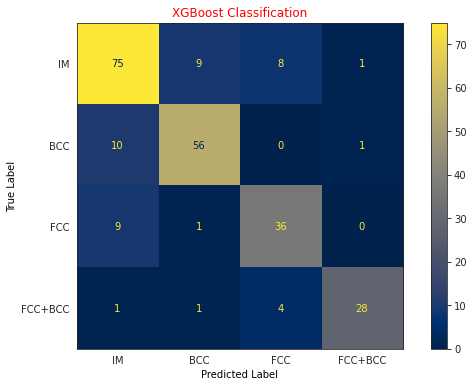

In [92]:
from sklearn.metrics import plot_confusion_matrix
class_names = ['IM', 'BCC', 'FCC', 'FCC+BCC']
cmplot= plot_confusion_matrix(model_xgb_hyperkn, X_test_fullkn_xg, y_test_fullkn_xg, display_labels= class_names, cmap='cividis')
cmplot.ax_.set_title('XGBoost Classification', color='red')
plt.xlabel('Predicted Label', color='black')
plt.ylabel('True Label', color='black')
plt.gcf().axes[0].tick_params(color='black')
plt.gcf().axes[1].tick_params(color='black')
plt.gcf().set_size_inches(10,6)
plt.savefig('XGB_Confused_1.png', format='png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

## Hyper-parameter tuning for SVC

In [63]:
from sklearn.svm import SVC
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def objective(trial):
    # Define the hyperparameters to be tuned
    param = {
        'C': trial.suggest_loguniform('C', 1e-3, 1e3),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 2, 5),  # only meaningful for 'poly' kernel
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }

    # Use the suggested random state value in train_test_split if available
    random_state = trial.suggest_categorical('random_state', [0, 25, 100, None])

    # Assuming X_knn and y are predefined
    X_train, X_test, y_train, y_test = train_test_split(X_knn, y, test_size=0.2, random_state=random_state)

    # Initialize the model
    model = SVC(**param)

    # Train the model
    model.fit(X_train, y_train)

    # Predict the test set
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    print(f"Model Accuracy: {round(accuracy, 6)}")
    print(f"Model F1-score: {round(f1, 6)}")
    print(f"Model precision-score: {round(precision, 6)}")
    print(f"Model recall-score: {round(recall, 6)}")
    print(f"Model Parameters: {param}")

    return accuracy  # return the objective value to be maximized

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=50)

    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


[I 2024-06-10 08:38:54,093] A new study created in memory with name: no-name-aa6925bc-02f4-44f0-8661-9ceb8ea43eaa
[I 2024-06-10 08:38:54,133] Trial 0 finished with value: 0.7041666666666667 and parameters: {'C': 11.443776806070208, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale', 'random_state': 25}. Best is trial 0 with value: 0.7041666666666667.
[I 2024-06-10 08:38:54,173] Trial 1 finished with value: 0.625 and parameters: {'C': 135.83537145321472, 'kernel': 'poly', 'degree': 5, 'gamma': 'scale', 'random_state': 25}. Best is trial 0 with value: 0.7041666666666667.
[I 2024-06-10 08:38:54,210] Trial 2 finished with value: 0.6666666666666666 and parameters: {'C': 3.1023160001326504, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale', 'random_state': None}. Best is trial 0 with value: 0.7041666666666667.
[I 2024-06-10 08:38:54,251] Trial 3 finished with value: 0.475 and parameters: {'C': 786.1430191539845, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale', 'random_state': None}. Best is tr

Model Accuracy: 0.704167
Model F1-score: 0.701697
Model precision-score: 0.707087
Model recall-score: 0.704167
Model Parameters: {'C': 11.443776806070208, 'kernel': 'poly', 'degree': 2, 'gamma': 'scale'}
Model Accuracy: 0.625
Model F1-score: 0.626623
Model precision-score: 0.639907
Model recall-score: 0.625
Model Parameters: {'C': 135.83537145321472, 'kernel': 'poly', 'degree': 5, 'gamma': 'scale'}
Model Accuracy: 0.666667
Model F1-score: 0.661263
Model precision-score: 0.733019
Model recall-score: 0.666667
Model Parameters: {'C': 3.1023160001326504, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}
Model Accuracy: 0.475
Model F1-score: 0.474853
Model precision-score: 0.490695
Model recall-score: 0.475
Model Parameters: {'C': 786.1430191539845, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale'}
Model Accuracy: 0.670833
Model F1-score: 0.667192
Model precision-score: 0.680744
Model recall-score: 0.670833
Model Parameters: {'C': 1.7130462150477703, 'kernel': 'linear', 'degree': 5, 'gamma

[I 2024-06-10 08:38:54,376] Trial 5 finished with value: 0.3333333333333333 and parameters: {'C': 0.00402837374876377, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale', 'random_state': 25}. Best is trial 0 with value: 0.7041666666666667.
[I 2024-06-10 08:38:54,443] Trial 6 finished with value: 0.3 and parameters: {'C': 0.006872871159987763, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale', 'random_state': 100}. Best is trial 0 with value: 0.7041666666666667.
[I 2024-06-10 08:38:54,506] Trial 7 finished with value: 0.3333333333333333 and parameters: {'C': 0.013448770058866983, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'auto', 'random_state': 25}. Best is trial 0 with value: 0.7041666666666667.
[I 2024-06-10 08:38:54,555] Trial 8 finished with value: 0.7166666666666667 and parameters: {'C': 873.6394162240533, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': None}. Best is trial 8 with value: 0.7166666666666667.


Model Accuracy: 0.333333
Model F1-score: 0.166667
Model precision-score: 0.111111
Model recall-score: 0.333333
Model Parameters: {'C': 0.00402837374876377, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale'}
Model Accuracy: 0.3
Model F1-score: 0.138462
Model precision-score: 0.09
Model recall-score: 0.3
Model Parameters: {'C': 0.006872871159987763, 'kernel': 'sigmoid', 'degree': 3, 'gamma': 'scale'}
Model Accuracy: 0.333333
Model F1-score: 0.166667
Model precision-score: 0.111111
Model recall-score: 0.333333
Model Parameters: {'C': 0.013448770058866983, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'auto'}
Model Accuracy: 0.716667
Model F1-score: 0.716344
Model precision-score: 0.718418
Model recall-score: 0.716667
Model Parameters: {'C': 873.6394162240533, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}


[I 2024-06-10 08:38:54,609] Trial 9 finished with value: 0.5125 and parameters: {'C': 0.6891542363284545, 'kernel': 'sigmoid', 'degree': 4, 'gamma': 'scale', 'random_state': None}. Best is trial 8 with value: 0.7166666666666667.
[I 2024-06-10 08:38:54,662] Trial 10 finished with value: 0.75 and parameters: {'C': 51.50164743258312, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'random_state': 0}. Best is trial 10 with value: 0.75.
[I 2024-06-10 08:38:54,719] Trial 11 finished with value: 0.7541666666666667 and parameters: {'C': 988.0431579860182, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'random_state': 0}. Best is trial 11 with value: 0.7541666666666667.
[I 2024-06-10 08:38:54,771] Trial 12 finished with value: 0.7666666666666667 and parameters: {'C': 40.828565217871315, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'random_state': 0}. Best is trial 12 with value: 0.7666666666666667.


Model Accuracy: 0.5125
Model F1-score: 0.514567
Model precision-score: 0.52948
Model recall-score: 0.5125
Model Parameters: {'C': 0.6891542363284545, 'kernel': 'sigmoid', 'degree': 4, 'gamma': 'scale'}
Model Accuracy: 0.75
Model F1-score: 0.752769
Model precision-score: 0.76286
Model recall-score: 0.75
Model Parameters: {'C': 51.50164743258312, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto'}
Model Accuracy: 0.754167
Model F1-score: 0.757594
Model precision-score: 0.767009
Model recall-score: 0.754167
Model Parameters: {'C': 988.0431579860182, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto'}
Model Accuracy: 0.766667
Model F1-score: 0.768408
Model precision-score: 0.776232
Model recall-score: 0.766667
Model Parameters: {'C': 40.828565217871315, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto'}


[I 2024-06-10 08:38:54,825] Trial 13 finished with value: 0.7458333333333333 and parameters: {'C': 74.27169315750919, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'random_state': 0}. Best is trial 12 with value: 0.7666666666666667.
[I 2024-06-10 08:38:54,879] Trial 14 finished with value: 0.5916666666666667 and parameters: {'C': 0.22660208841703905, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'random_state': 0}. Best is trial 12 with value: 0.7666666666666667.


Model Accuracy: 0.745833
Model F1-score: 0.749739
Model precision-score: 0.762803
Model recall-score: 0.745833
Model Parameters: {'C': 74.27169315750919, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto'}
Model Accuracy: 0.591667
Model F1-score: 0.58262
Model precision-score: 0.67549
Model recall-score: 0.591667
Model Parameters: {'C': 0.22660208841703905, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto'}


[I 2024-06-10 08:39:05,757] Trial 15 finished with value: 0.6708333333333333 and parameters: {'C': 258.7298230571369, 'kernel': 'linear', 'degree': 4, 'gamma': 'auto', 'random_state': 0}. Best is trial 12 with value: 0.7666666666666667.
[I 2024-06-10 08:39:05,808] Trial 16 finished with value: 0.7666666666666667 and parameters: {'C': 12.095397949603722, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 0}. Best is trial 12 with value: 0.7666666666666667.
[I 2024-06-10 08:39:05,858] Trial 17 finished with value: 0.7791666666666667 and parameters: {'C': 19.50535235570742, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 17 with value: 0.7791666666666667.
[I 2024-06-10 08:39:05,916] Trial 18 finished with value: 0.4791666666666667 and parameters: {'C': 0.07363824248795063, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 17 with value: 0.7791666666666667.


Model Accuracy: 0.670833
Model F1-score: 0.674441
Model precision-score: 0.702916
Model recall-score: 0.670833
Model Parameters: {'C': 258.7298230571369, 'kernel': 'linear', 'degree': 4, 'gamma': 'auto'}
Model Accuracy: 0.766667
Model F1-score: 0.767122
Model precision-score: 0.778216
Model recall-score: 0.766667
Model Parameters: {'C': 12.095397949603722, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.779167
Model F1-score: 0.780133
Model precision-score: 0.785171
Model recall-score: 0.779167
Model Parameters: {'C': 19.50535235570742, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.479167
Model F1-score: 0.431061
Model precision-score: 0.613323
Model recall-score: 0.479167
Model Parameters: {'C': 0.07363824248795063, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}


[I 2024-06-10 08:39:06,432] Trial 19 finished with value: 0.65 and parameters: {'C': 13.676351071910156, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 17 with value: 0.7791666666666667.
[I 2024-06-10 08:39:06,487] Trial 20 finished with value: 0.775 and parameters: {'C': 30.055131769394848, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 17 with value: 0.7791666666666667.
[I 2024-06-10 08:39:06,541] Trial 21 finished with value: 0.775 and parameters: {'C': 21.7792886615306, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 17 with value: 0.7791666666666667.
[I 2024-06-10 08:39:06,594] Trial 22 finished with value: 0.7958333333333333 and parameters: {'C': 6.099888487322135, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 22 with value: 0.7958333333333333.


Model Accuracy: 0.65
Model F1-score: 0.658448
Model precision-score: 0.685129
Model recall-score: 0.65
Model Parameters: {'C': 13.676351071910156, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.775
Model F1-score: 0.775123
Model precision-score: 0.777396
Model recall-score: 0.775
Model Parameters: {'C': 30.055131769394848, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.775
Model F1-score: 0.775942
Model precision-score: 0.780572
Model recall-score: 0.775
Model Parameters: {'C': 21.7792886615306, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.795833
Model F1-score: 0.796918
Model precision-score: 0.799957
Model recall-score: 0.795833
Model Parameters: {'C': 6.099888487322135, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}


[I 2024-06-10 08:39:06,644] Trial 23 finished with value: 0.7666666666666667 and parameters: {'C': 3.4153099610376048, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 22 with value: 0.7958333333333333.
[I 2024-06-10 08:39:06,696] Trial 24 finished with value: 0.6208333333333333 and parameters: {'C': 0.4950001234618289, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 22 with value: 0.7958333333333333.
[I 2024-06-10 08:39:06,745] Trial 25 finished with value: 0.7666666666666667 and parameters: {'C': 3.3715684761928277, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 22 with value: 0.7958333333333333.
[I 2024-06-10 08:39:06,801] Trial 26 finished with value: 0.7708333333333334 and parameters: {'C': 225.95236361417216, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 22 with value: 0.7958333333333333.
[I 2024-06-10 08:39:06,842] Trial 27 finished with v

Model Accuracy: 0.766667
Model F1-score: 0.767358
Model precision-score: 0.771281
Model recall-score: 0.766667
Model Parameters: {'C': 3.4153099610376048, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.620833
Model F1-score: 0.626967
Model precision-score: 0.676172
Model recall-score: 0.620833
Model Parameters: {'C': 0.4950001234618289, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.766667
Model F1-score: 0.767358
Model precision-score: 0.771281
Model recall-score: 0.766667
Model Parameters: {'C': 3.3715684761928277, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.770833
Model F1-score: 0.772012
Model precision-score: 0.781408
Model recall-score: 0.770833
Model Parameters: {'C': 225.95236361417216, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.408333
Model F1-score: 0.335378
Model precision-score: 0.626633
Model recall-score: 0.408333
Model Parameters: {'C': 0.0012019888559511973, 'kernel': 'linear', 'degree': 4, '

[I 2024-06-10 08:39:06,892] Trial 28 finished with value: 0.31666666666666665 and parameters: {'C': 0.06641150760468448, 'kernel': 'poly', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 22 with value: 0.7958333333333333.
[I 2024-06-10 08:39:06,935] Trial 29 finished with value: 0.6458333333333334 and parameters: {'C': 4.6087137975317605, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto', 'random_state': 100}. Best is trial 22 with value: 0.7958333333333333.
[I 2024-06-10 08:39:06,985] Trial 30 finished with value: 0.8 and parameters: {'C': 6.403020898520503, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,035] Trial 31 finished with value: 0.7916666666666666 and parameters: {'C': 7.702236745663394, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,084] Trial 32 finished with value: 0.7958333333333333 and parameters: {'

Model Accuracy: 0.316667
Model F1-score: 0.172622
Model precision-score: 0.666525
Model recall-score: 0.316667
Model Parameters: {'C': 0.06641150760468448, 'kernel': 'poly', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.645833
Model F1-score: 0.647011
Model precision-score: 0.68493
Model recall-score: 0.645833
Model Parameters: {'C': 4.6087137975317605, 'kernel': 'poly', 'degree': 2, 'gamma': 'auto'}
Model Accuracy: 0.8
Model F1-score: 0.800965
Model precision-score: 0.803432
Model recall-score: 0.8
Model Parameters: {'C': 6.403020898520503, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.791667
Model F1-score: 0.792596
Model precision-score: 0.795425
Model recall-score: 0.791667
Model Parameters: {'C': 7.702236745663394, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.795833
Model F1-score: 0.796767
Model precision-score: 0.799325
Model recall-score: 0.795833
Model Parameters: {'C': 7.234554253134644, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}


[I 2024-06-10 08:39:07,134] Trial 33 finished with value: 0.7958333333333333 and parameters: {'C': 8.45034048397542, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,182] Trial 34 finished with value: 0.49583333333333335 and parameters: {'C': 1.3246904868453764, 'kernel': 'poly', 'degree': 5, 'gamma': 'scale', 'random_state': 25}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,232] Trial 35 finished with value: 0.7958333333333333 and parameters: {'C': 7.48266568954221, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,283] Trial 36 finished with value: 0.7708333333333334 and parameters: {'C': 1.7943947268241682, 'kernel': 'rbf', 'degree': 4, 'gamma': 'scale', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,331] Trial 37 finished with value: 0.4625 and parameters: {'C': 97.06742920890028, 'kernel

Model Accuracy: 0.795833
Model F1-score: 0.796552
Model precision-score: 0.799082
Model recall-score: 0.795833
Model Parameters: {'C': 8.45034048397542, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.495833
Model F1-score: 0.463285
Model precision-score: 0.619089
Model recall-score: 0.495833
Model Parameters: {'C': 1.3246904868453764, 'kernel': 'poly', 'degree': 5, 'gamma': 'scale'}
Model Accuracy: 0.795833
Model F1-score: 0.796767
Model precision-score: 0.799325
Model recall-score: 0.795833
Model Parameters: {'C': 7.48266568954221, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.770833
Model F1-score: 0.771272
Model precision-score: 0.775842
Model recall-score: 0.770833
Model Parameters: {'C': 1.7943947268241682, 'kernel': 'rbf', 'degree': 4, 'gamma': 'scale'}
Model Accuracy: 0.4625
Model F1-score: 0.474831
Model precision-score: 0.510625
Model recall-score: 0.4625
Model Parameters: {'C': 97.06742920890028, 'kernel': 'sigmoid', 'degree': 5, 'gamma': 

[I 2024-06-10 08:39:07,376] Trial 38 finished with value: 0.49166666666666664 and parameters: {'C': 0.27745956541462974, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale', 'random_state': 25}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,473] Trial 39 finished with value: 0.6541666666666667 and parameters: {'C': 1.8054027356634292, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto', 'random_state': None}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,525] Trial 40 finished with value: 0.7875 and parameters: {'C': 6.576930514346762, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,575] Trial 41 finished with value: 0.7958333333333333 and parameters: {'C': 8.339024427571307, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 30 with value: 0.8.


Model Accuracy: 0.491667
Model F1-score: 0.448011
Model precision-score: 0.676471
Model recall-score: 0.491667
Model Parameters: {'C': 0.27745956541462974, 'kernel': 'poly', 'degree': 3, 'gamma': 'scale'}
Model Accuracy: 0.654167
Model F1-score: 0.655816
Model precision-score: 0.6687
Model recall-score: 0.654167
Model Parameters: {'C': 1.8054027356634292, 'kernel': 'linear', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.7875
Model F1-score: 0.788231
Model precision-score: 0.792617
Model recall-score: 0.7875
Model Parameters: {'C': 6.576930514346762, 'kernel': 'rbf', 'degree': 3, 'gamma': 'scale'}
Model Accuracy: 0.795833
Model F1-score: 0.796552
Model precision-score: 0.799082
Model recall-score: 0.795833
Model Parameters: {'C': 8.339024427571307, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}


[I 2024-06-10 08:39:07,625] Trial 42 finished with value: 0.775 and parameters: {'C': 2.6248490803909266, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,676] Trial 43 finished with value: 0.6958333333333333 and parameters: {'C': 1.0494712141003868, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,729] Trial 44 finished with value: 0.5291666666666667 and parameters: {'C': 5.658389487634013, 'kernel': 'sigmoid', 'degree': 5, 'gamma': 'auto', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,779] Trial 45 finished with value: 0.7166666666666667 and parameters: {'C': 14.753680685411767, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'random_state': None}. Best is trial 30 with value: 0.8.


Model Accuracy: 0.775
Model F1-score: 0.775696
Model precision-score: 0.780645
Model recall-score: 0.775
Model Parameters: {'C': 2.6248490803909266, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.695833
Model F1-score: 0.699399
Model precision-score: 0.723469
Model recall-score: 0.695833
Model Parameters: {'C': 1.0494712141003868, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.529167
Model F1-score: 0.541058
Model precision-score: 0.577216
Model recall-score: 0.529167
Model Parameters: {'C': 5.658389487634013, 'kernel': 'sigmoid', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.716667
Model F1-score: 0.716908
Model precision-score: 0.717221
Model recall-score: 0.716667
Model Parameters: {'C': 14.753680685411767, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto'}


[I 2024-06-10 08:39:07,833] Trial 46 finished with value: 0.7333333333333333 and parameters: {'C': 50.0170331108297, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto', 'random_state': 25}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,885] Trial 47 finished with value: 0.65 and parameters: {'C': 0.6730773101987023, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,933] Trial 48 finished with value: 0.4875 and parameters: {'C': 157.6262364097433, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'auto', 'random_state': 100}. Best is trial 30 with value: 0.8.
[I 2024-06-10 08:39:07,986] Trial 49 finished with value: 0.7666666666666667 and parameters: {'C': 29.266990157675004, 'kernel': 'rbf', 'degree': 5, 'gamma': 'scale', 'random_state': None}. Best is trial 30 with value: 0.8.


Model Accuracy: 0.733333
Model F1-score: 0.732944
Model precision-score: 0.736273
Model recall-score: 0.733333
Model Parameters: {'C': 50.0170331108297, 'kernel': 'rbf', 'degree': 5, 'gamma': 'auto'}
Model Accuracy: 0.65
Model F1-score: 0.655428
Model precision-score: 0.697223
Model recall-score: 0.65
Model Parameters: {'C': 0.6730773101987023, 'kernel': 'rbf', 'degree': 4, 'gamma': 'auto'}
Model Accuracy: 0.4875
Model F1-score: 0.501287
Model precision-score: 0.539916
Model recall-score: 0.4875
Model Parameters: {'C': 157.6262364097433, 'kernel': 'sigmoid', 'degree': 2, 'gamma': 'auto'}
Model Accuracy: 0.766667
Model F1-score: 0.765066
Model precision-score: 0.766816
Model recall-score: 0.766667
Model Parameters: {'C': 29.266990157675004, 'kernel': 'rbf', 'degree': 5, 'gamma': 'scale'}
Number of finished trials: 50
Best trial:
  Value: 0.8
  Params: 
    C: 6.403020898520503
    kernel: rbf
    degree: 5
    gamma: auto
    random_state: 100


## ROC and AUC for SVC

In [130]:
knn_pipeline2= Pipeline(steps=[('imputer', KNNImputer(n_neighbors=3)),('RobustScaler', RobustScaler())])
X_knn2 =knn_pipeline2.fit_transform(X_full)
X_train_fullkn_sv, X_test_fullkn_sv, y_train_fullkn_sv, y_test_fullkn_sv = train_test_split(X_knn2, y_full, test_size=0.20, random_state=42)

## Hyper-tuned SVC
best_params = trial.params
model_svc_hyperkn = SVC(probability=True, **best_params).fit(X_train_fullkn_sv, y_train_fullkn_sv)
probs_svc_hyper = model_svc_hyperkn.predict_proba(X_test_fullkn_sv)#[:, 1]

auc_svc = roc_auc_score(y_test_fullkn_sv, probs_svc_hyper, multi_class='ovr')
print('AUC of SVC: {:.4f}'.format(auc_svc))


SVC_KNN = SVC(probability=True, **best_params) #random_state= 100, min_samples_split= 6,

scores_cv_svc = cross_val_score(SVC_KNN, X_knn2, y_full, cv=10, scoring='roc_auc_ovr')
    
scores_cv_svc_mean= scores_cv_svc.mean()
scores_cv_svc_std= scores_cv_svc.std()
#print('10-fold CV of RFC', (scores_cv_rf))
print('10-fold CV mean of SVC: {:.4f}'.format(scores_cv_svc_mean))
print('10-fold CV std of SVC: {:.4f}'.format(scores_cv_svc_std))

TypeError: __init__() got an unexpected keyword argument 'criterion'

### Confusion Matrix for SVC

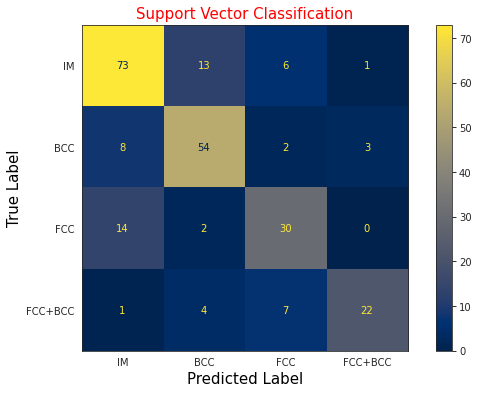

In [98]:
from sklearn.metrics import plot_confusion_matrix
class_names = ['IM', 'BCC', 'FCC', 'FCC+BCC']
cmplot= plot_confusion_matrix(model_svc_hyperkn, X_test_fullkn_sv, y_test_fullkn_sv, display_labels= class_names, cmap='cividis')
cmplot.ax_.set_title('Support Vector Classification', color='red', fontsize=15)
plt.xlabel('Predicted Label', color='black', fontsize=15)
plt.ylabel('True Label', color='black', fontsize=15)
plt.gcf().axes[0].tick_params(color='black')
plt.gcf().axes[1].tick_params(color='black')
plt.gcf().set_size_inches(10,6)
# plt.savefig('SVC_Confused_1.png', format='png', dpi=500, bbox_inches='tight', transparent=True)
plt.show()

In [66]:
from sklearn.metrics import auc

### ROC Curve for RFC Model for each Phase

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

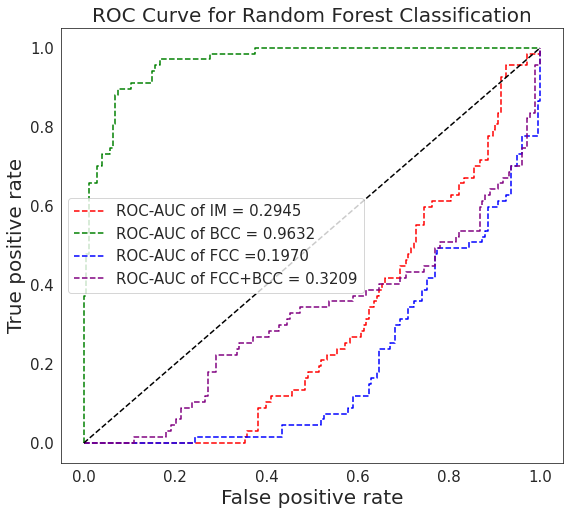

In [99]:
sns.set_style('white')
plt.figure(figsize=(9,8))

fpr0, tpr0, thresh0 = roc_curve(y_test_fullkn_rf, probs_rf_hyper[:,0], pos_label=1) #MIP
fpr1, tpr1, thresh1 = roc_curve(y_test_fullkn_dt, probs_rf_hyper[:,1], pos_label=1) #BCC
fpr2, tpr2, thresh2 = roc_curve(y_test_fullkn_kn, probs_rf_hyper[:,2], pos_label=1) #FCC
fpr3, tpr3, thresh3 = roc_curve(y_test_fullkn_xg, probs_rf_hyper[:,3], pos_label=1) #BCC+FCC

roc_auc0 = auc(fpr0, tpr0)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)

random_probs = [0 for i in range(len(y_test_fullkn_rf))]
p_fpr, p_tpr, _ = roc_curve(y_test_fullkn_rf, random_probs, pos_label=1)


plt.plot(fpr0, tpr0, linestyle= '--', color= 'red', label= 'ROC-AUC of IM = %0.4f' % roc_auc0, markersize=1)
plt.plot(fpr1, tpr1 , linestyle= '--', color= 'green', label= 'ROC-AUC of BCC = %0.4f' % roc_auc1, markersize=1)
plt.plot(fpr2, tpr2,  linestyle= '--', color= 'blue',label= 'ROC-AUC of FCC =%0.4f' % roc_auc2, markersize=1 )
plt.plot(fpr3, tpr3,  linestyle= '--', color= 'purple', label= 'ROC-AUC of FCC+BCC = %0.4f' % roc_auc3,markersize=1)
plt.plot(p_fpr, p_tpr, linestyle= '--', color= 'black')

plt.title('ROC Curve for Random Forest Classification', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.legend(loc='best', fontsize=15)
plt.xticks( fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('ROC', dpi=300)

In [100]:
probs_rf_hyper

array([[0.21184439, 0.2432196 , 0.4405556 , 0.10438042],
       [0.06991928, 0.03274393, 0.04638007, 0.85095672],
       [0.63137772, 0.31327813, 0.02023365, 0.0351105 ],
       [0.13833522, 0.05630613, 0.65463416, 0.15072449],
       [0.29129098, 0.14087704, 0.49155519, 0.07627679],
       [0.43590504, 0.39329018, 0.08605963, 0.08474516],
       [0.5363573 , 0.12099366, 0.23298454, 0.10966451],
       [0.51527079, 0.18933545, 0.08405824, 0.21133553],
       [0.08827546, 0.90583147, 0.00321575, 0.00267732],
       [0.07851659, 0.28879981, 0.45664188, 0.17604172],
       [0.14845057, 0.04214079, 0.76655784, 0.0428508 ],
       [0.10103852, 0.85169384, 0.02293319, 0.02433446],
       [0.08484483, 0.88357301, 0.01750996, 0.0140722 ],
       [0.04714431, 0.05067227, 0.60453123, 0.29765219],
       [0.24539685, 0.04951777, 0.63294814, 0.07213724],
       [0.41051368, 0.49129414, 0.06195384, 0.03623833],
       [0.43049021, 0.12534017, 0.28529751, 0.1588721 ],
       [0.7094151 , 0.08821561,

### ROC Curve for MIP Phase

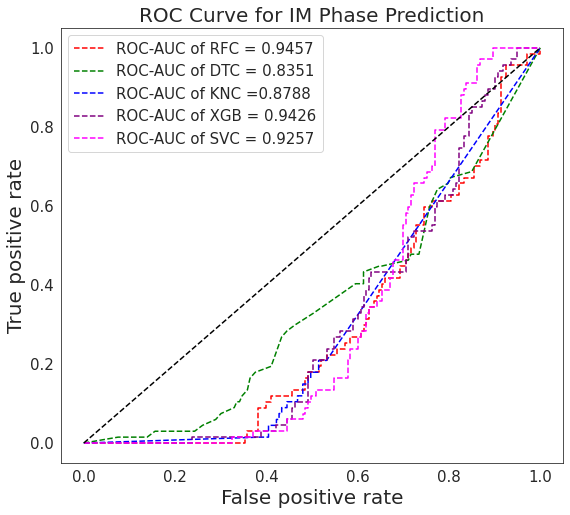

In [106]:
sns.set_style('white')
plt.figure(figsize=(9,8))

fpr1, tpr1, thresh1 = roc_curve(y_test_fullkn_rf, probs_rf_hyper[:,0], pos_label=1) #RFC
fpr2, tpr2, thresh2 = roc_curve(y_test_fullkn_dt, probs_dtc_hyper[:,0], pos_label=1) #DTC
fpr3, tpr3, thresh3 = roc_curve(y_test_fullkn_kn, probs_knc_hyper[:,0], pos_label=1) #KNC
fpr4, tpr4, thresh4 = roc_curve(y_test_fullkn_xg, probs_xgb_hyper[:,0], pos_label=1) #XGB
fpr6, tpr6, thresh6 = roc_curve(y_test_fullkn_sv, probs_svc_hyper[:,0], pos_label=1) #SVC

a= roc_auc_score(y_test_fullkn_rf, probs_rf_hyper, multi_class= 'ovr')
b= roc_auc_score(y_test_fullkn_dt, probs_dtc_hyper, multi_class= 'ovr')
c= roc_auc_score(y_test_fullkn_kn, probs_knc_hyper, multi_class= 'ovr')
d= roc_auc_score(y_test_fullkn_xg, probs_xgb_hyper, multi_class= 'ovr')
e= roc_auc_score(y_test_fullkn_sv, probs_svc_hyper, multi_class= 'ovr')

random_probs = [0 for i in range(len(y_test_fullkn_rf))]
p_fpr, p_tpr, _ = roc_curve(y_test_fullkn_rf, random_probs, pos_label=1)

rf_roc_auc = a
dtc_roc_auc = b
knc_roc_auc = c #auc(fpr3, tpr3)
xgb_roc_auc = d  #auc(fpr4, tpr4)
svc_roc_auc = e  #auc(fpr6, tpr6)

plt.plot(fpr1, tpr1, linestyle= '--', color= 'red', label= 'ROC-AUC of RFC = %0.4f' % rf_roc_auc, markersize=1)
plt.plot(fpr2, tpr2 ,  linestyle= '--', color= 'green', label= 'ROC-AUC of DTC = %0.4f' % dtc_roc_auc, markersize=1)
plt.plot(fpr3, tpr3,  linestyle= '--', color= 'blue',label= 'ROC-AUC of KNC =%0.4f' % knc_roc_auc, markersize=1 )
plt.plot(fpr4, tpr4,  linestyle= '--', color= 'purple', label= 'ROC-AUC of XGB = %0.4f' % xgb_roc_auc,markersize=1)

# #plt.plot(fpr5, tpr5,  linestyle= '--', color= 'cyan',label= 'AUC of Gradient Boost =%0.2f' % GB_roc_auc )
plt.plot(fpr6, tpr6,  linestyle= '--', color= 'magenta', label= 'ROC-AUC of SVC = %0.4f' % svc_roc_auc, markersize=1)
plt.plot(p_fpr, p_tpr,  linestyle= '--', color= 'black' )
plt.title('ROC Curve for IM Phase Prediction', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.legend(loc='best', fontsize=15)
plt.xticks( fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('IM.png', format='png', dpi=500, bbox_inches='tight', transparent=True)
#plt.savefig('ROC', dpi=300)

### ROC Curve for BCC Phase

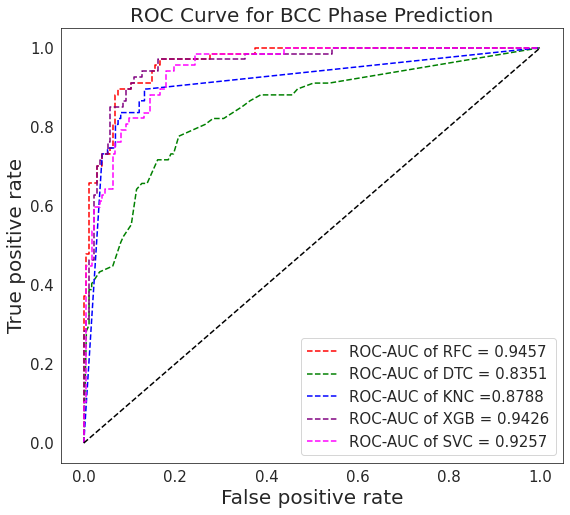

In [107]:
sns.set_style('white')
plt.figure(figsize=(9,8))

fpr1, tpr1, thresh1 = roc_curve(y_test_fullkn_rf, probs_rf_hyper[:,1], pos_label=1) #RFC
fpr2, tpr2, thresh2 = roc_curve(y_test_fullkn_dt, probs_dtc_hyper[:,1], pos_label=1) #DTC
fpr3, tpr3, thresh3 = roc_curve(y_test_fullkn_kn, probs_knc_hyper[:,1], pos_label=1) #KNC
fpr4, tpr4, thresh4 = roc_curve(y_test_fullkn_xg, probs_xgb_hyper[:,1], pos_label=1) #XGB
fpr6, tpr6, thresh6 = roc_curve(y_test_fullkn_sv, probs_svc_hyper[:,1], pos_label=1) #SVC

a= roc_auc_score(y_test_fullkn_rf, probs_rf_hyper, multi_class= 'ovr')
b= roc_auc_score(y_test_fullkn_dt, probs_dtc_hyper, multi_class= 'ovr')
c= roc_auc_score(y_test_fullkn_kn, probs_knc_hyper, multi_class= 'ovr')
d= roc_auc_score(y_test_fullkn_xg, probs_xgb_hyper, multi_class= 'ovr')
e= roc_auc_score(y_test_fullkn_sv, probs_svc_hyper, multi_class= 'ovr')

random_probs = [0 for i in range(len(y_test_fullkn_rf))]
p_fpr, p_tpr, _ = roc_curve(y_test_fullkn_rf, random_probs, pos_label=1)

rf_roc_auc = a
dtc_roc_auc = b
knc_roc_auc = c #auc(fpr3, tpr3)
xgb_roc_auc = d  #auc(fpr4, tpr4)
svc_roc_auc = e  #auc(fpr6, tpr6)

plt.plot(fpr1, tpr1, linestyle= '--', color= 'red', label= 'ROC-AUC of RFC = %0.4f' % rf_roc_auc, markersize=1)
plt.plot(fpr2, tpr2 ,  linestyle= '--', color= 'green', label= 'ROC-AUC of DTC = %0.4f' % dtc_roc_auc, markersize=1)
plt.plot(fpr3, tpr3,  linestyle= '--', color= 'blue',label= 'ROC-AUC of KNC =%0.4f' % knc_roc_auc, markersize=1 )
plt.plot(fpr4, tpr4,  linestyle= '--', color= 'purple', label= 'ROC-AUC of XGB = %0.4f' % xgb_roc_auc,markersize=1)

# #plt.plot(fpr5, tpr5,  linestyle= '--', color= 'cyan',label= 'AUC of Gradient Boost =%0.2f' % GB_roc_auc )
plt.plot(fpr6, tpr6,  linestyle= '--', color= 'magenta', label= 'ROC-AUC of SVC = %0.4f' % svc_roc_auc, markersize=1)
plt.plot(p_fpr, p_tpr,  linestyle= '--', color= 'black' )
plt.title('ROC Curve for BCC Phase Prediction', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.legend(loc='best', fontsize=15)
plt.xticks( fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('BCC.png', format='png', dpi=500, bbox_inches='tight', transparent=True)
#plt.savefig('ROC', dpi=300)

In [108]:
print(np.size(y_test_fullkn_rf))
print(np.size(probs_rf_hyper[:,2]))

240
240


### ROC Curve for FCC Phase

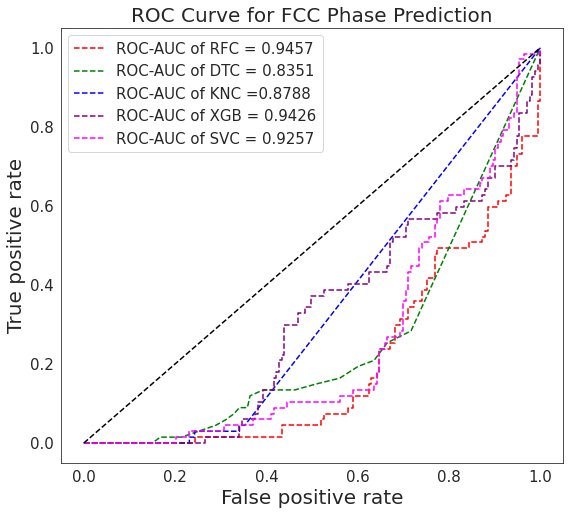

In [109]:
sns.set_style('white')
plt.figure(figsize=(9,8))

fpr1, tpr1, thresh1 = roc_curve(y_test_fullkn_rf, probs_rf_hyper[:,2], pos_label=1) #RFC
fpr2, tpr2, thresh2 = roc_curve(y_test_fullkn_dt, probs_dtc_hyper[:,2], pos_label=1) #DTC
fpr3, tpr3, thresh3 = roc_curve(y_test_fullkn_kn, probs_knc_hyper[:,2], pos_label=1) #KNC
fpr4, tpr4, thresh4 = roc_curve(y_test_fullkn_xg, probs_xgb_hyper[:,2], pos_label=1) #XGB
fpr6, tpr6, thresh6 = roc_curve(y_test_fullkn_sv, probs_svc_hyper[:,2], pos_label=1) #SVC


# a = auc(fpr1, tpr1)

a= roc_auc_score(y_test_fullkn_rf, probs_rf_hyper, multi_class = 'ovr')
b= roc_auc_score(y_test_fullkn_dt, probs_dtc_hyper, multi_class= 'ovr')
c= roc_auc_score(y_test_fullkn_kn, probs_knc_hyper, multi_class= 'ovr')
d= roc_auc_score(y_test_fullkn_xg, probs_xgb_hyper, multi_class= 'ovr')
e= roc_auc_score(y_test_fullkn_sv, probs_svc_hyper, multi_class= 'ovr')

random_probs = [0 for i in range(len(y_test_fullkn_rf))]
p_fpr, p_tpr, _ = roc_curve(y_test_fullkn_rf, random_probs, pos_label=1)

rf_roc_auc = a
dtc_roc_auc = b
knc_roc_auc = c #auc(fpr3, tpr3)
xgb_roc_auc = d  #auc(fpr4, tpr4)
svc_roc_auc = e  #auc(fpr6, tpr6)

plt.plot(fpr1, tpr1, linestyle= '--', color= 'red', label= 'ROC-AUC of RFC = %0.4f' % rf_roc_auc, markersize=1)
plt.plot(fpr2, tpr2 ,  linestyle= '--', color= 'green', label= 'ROC-AUC of DTC = %0.4f' % dtc_roc_auc, markersize=1)
plt.plot(fpr3, tpr3,  linestyle= '--', color= 'blue',label= 'ROC-AUC of KNC =%0.4f' % knc_roc_auc, markersize=1 )
plt.plot(fpr4, tpr4,  linestyle= '--', color= 'purple', label= 'ROC-AUC of XGB = %0.4f' % xgb_roc_auc,markersize=1)

# #plt.plot(fpr5, tpr5,  linestyle= '--', color= 'cyan',label= 'AUC of Gradient Boost =%0.2f' % GB_roc_auc )
plt.plot(fpr6, tpr6,  linestyle= '--', color= 'magenta', label= 'ROC-AUC of SVC = %0.4f' % svc_roc_auc, markersize=1)
plt.plot(p_fpr, p_tpr,  linestyle= '--', color= 'black' )
plt.title('ROC Curve for FCC Phase Prediction', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.legend(loc='best', fontsize=15)
plt.xticks( fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('FCC.png', format='png', dpi=500, bbox_inches='tight', transparent=True)
#plt.savefig('ROC', dpi=300)

### ROC Curve for FCC+BCC Phase

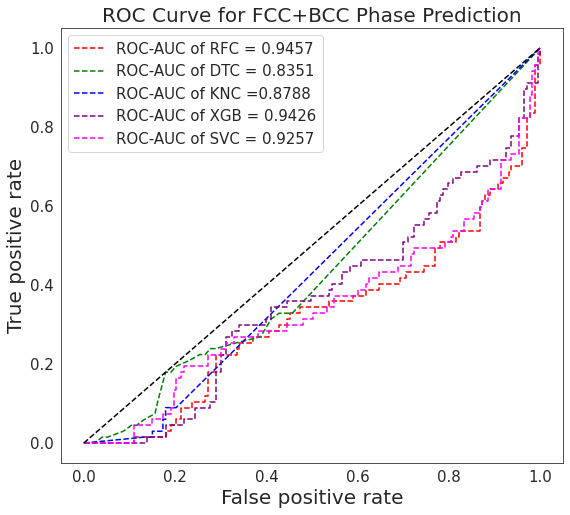

In [110]:
sns.set_style('white')
plt.figure(figsize=(9,8))

fpr1, tpr1, thresh1 = roc_curve(y_test_fullkn_rf, probs_rf_hyper[:,3], pos_label=1) #RFC
fpr2, tpr2, thresh2 = roc_curve(y_test_fullkn_dt, probs_dtc_hyper[:,3], pos_label=1) #DTC
fpr3, tpr3, thresh3 = roc_curve(y_test_fullkn_kn, probs_knc_hyper[:,3], pos_label=1) #KNC
fpr4, tpr4, thresh4 = roc_curve(y_test_fullkn_xg, probs_xgb_hyper[:,3], pos_label=1) #XGB
fpr6, tpr6, thresh6 = roc_curve(y_test_fullkn_sv, probs_svc_hyper[:,3], pos_label=1) #SVC

a= roc_auc_score(y_test_fullkn_rf, probs_rf_hyper, multi_class= 'ovr')
b= roc_auc_score(y_test_fullkn_dt, probs_dtc_hyper, multi_class= 'ovr')
c= roc_auc_score(y_test_fullkn_kn, probs_knc_hyper, multi_class= 'ovr')
d= roc_auc_score(y_test_fullkn_xg, probs_xgb_hyper, multi_class= 'ovr')
e= roc_auc_score(y_test_fullkn_sv, probs_svc_hyper, multi_class= 'ovr')

random_probs = [0 for i in range(len(y_test_fullkn_rf))]
p_fpr, p_tpr, _ = roc_curve(y_test_fullkn_rf, random_probs, pos_label=1)

rf_roc_auc = a
dtc_roc_auc = b
knc_roc_auc = c #auc(fpr3, tpr3)
xgb_roc_auc = d  #auc(fpr4, tpr4)
svc_roc_auc = e  #auc(fpr6, tpr6)

plt.plot(fpr1, tpr1, linestyle= '--', color= 'red', label= 'ROC-AUC of RFC = %0.4f' % rf_roc_auc, markersize=1)
plt.plot(fpr2, tpr2 ,  linestyle= '--', color= 'green', label= 'ROC-AUC of DTC = %0.4f' % dtc_roc_auc, markersize=1)
plt.plot(fpr3, tpr3,  linestyle= '--', color= 'blue',label= 'ROC-AUC of KNC =%0.4f' % knc_roc_auc, markersize=1 )
plt.plot(fpr4, tpr4,  linestyle= '--', color= 'purple', label= 'ROC-AUC of XGB = %0.4f' % xgb_roc_auc,markersize=1)

# #plt.plot(fpr5, tpr5,  linestyle= '--', color= 'cyan',label= 'AUC of Gradient Boost =%0.2f' % GB_roc_auc )
plt.plot(fpr6, tpr6,  linestyle= '--', color= 'magenta', label= 'ROC-AUC of SVC = %0.4f' % svc_roc_auc, markersize=1)
plt.plot(p_fpr, p_tpr,  linestyle= '--', color= 'black' )
plt.title('ROC Curve for FCC+BCC Phase Prediction', fontsize=20)
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.legend(loc='best', fontsize=15)
plt.xticks( fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('FCC_BCC.png', format='png', dpi=500, bbox_inches='tight', transparent=True)

#plt.savefig('', dpi=300)

### Comparing Performance of Each Model

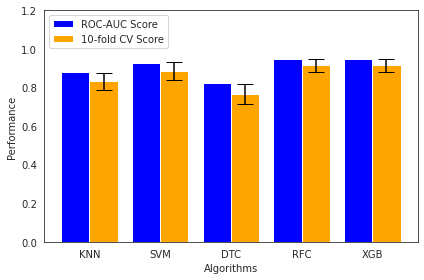

In [162]:
model_type = ['KNN', 'SVM', 'DTC', 'RFC', 'XGB']

knn_quantities = [auc_knc, scores_cv_knc_mean]
knn_std = scores_cv_knc_std

svc_quantities = [auc_svc, scores_cv_svc_mean]
svc_std = scores_cv_svc_std

dtc_quantities = [auc_dtc, scores_cv_dtc_mean]
dtc_std = scores_cv_dtc_std

rfc_quantities = [auc_rf, scores_cv_rf]
rfc_std = scores_cv_rf_std

xgb_quantities = [auc_xgb, scores_cv_xgb_mean]
xgb_std = scores_cv_xgb_std

std_vals = [knn_std, svc_std, dtc_std, rfc_std, xgb_std]
# Plotting bar chart

bar_width = 0.4
x = np.arange(len(model_type))
fig, ax = plt.subplots()
# plt.yticks((np.arange(0, 1.1, 0.1))
bar_knn0 = ax.bar(x[0] - bar_width/2, knn_quantities[0], bar_width, color='blue', label='ROC-AUC Score')
bar_knn1 = ax.bar(x[0] + bar_width/2, knn_quantities[1], bar_width, color='orange', label='10-fold CV Score')
ax.errorbar(x[0] + bar_width/2, knn_quantities[1], yerr=std_vals[0], fmt='none', ecolor='black', capsize=8)

bar_svm0 = ax.bar(x[1] - bar_width/2, svc_quantities[0], bar_width, color='blue')
bar_svm1 = ax.bar(x[1] + bar_width/2, svc_quantities[1], bar_width, color='orange')
ax.errorbar(x[1] + bar_width/2, svc_quantities[1], yerr=std_vals[1], fmt='none', ecolor='black', capsize=8)

bar_dtc0 = ax.bar(x[2] - bar_width/2, dtc_quantities[0], bar_width, color='blue')
bar_dtc1 = ax.bar(x[2] + bar_width/2, dtc_quantities[1], bar_width, color='orange')
ax.errorbar(x[2] + bar_width/2, dtc_quantities[1], yerr=std_vals[2], fmt='none', ecolor='black', capsize=8)

bar_rfc0 = ax.bar(x[3] - bar_width/2, rfc_quantities[0], bar_width, color='blue')
bar_rfc1 = ax.bar(x[3] + bar_width/2, rfc_quantities[1], bar_width, color='orange')
ax.errorbar(x[3] + bar_width/2, rfc_quantities[1], yerr=std_vals[3], fmt='none', ecolor='black', capsize=8)

bar_xgb0 = ax.bar(x[4] - bar_width/2, xgb_quantities[0], bar_width, color='blue')
bar_xgb1 = ax.bar(x[4] + bar_width/2, xgb_quantities[1], bar_width, color='orange')
ax.errorbar(x[4] + bar_width/2, xgb_quantities[1], yerr=std_vals[4], fmt='none', ecolor='black', capsize=8)

# Add labels, title, and legend
ax.set_xlabel('Algorithms')
ax.set_ylabel('Performance')
# ax.set_title('Bar Plot with Error Bars')
ax.set_xticks(x)
ax.set_xticklabels(model_type)
# plt.yticks((np.arange(0, 1.1, 0.1))
ax.legend(loc='upper left')
ax.set_ylim([0, 1.2])
# plt.yticks((np.arange(0, 1.1, 0.1))
# Show plot
plt.tight_layout()
plt.savefig('Performance.png', format='png', dpi=500, bbox_inches='tight', transparent=True)

plt.show()

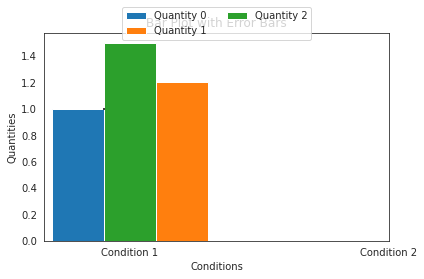

In [137]:
# Define x-axis conditions
conditions = ['Condition 1', 'Condition 2']

# Define quantities for each condition
quantities1 = [1.0, 1.2, 1.5]  # For Condition 1
quantities2 = [0.8, 1.3, 1.4]  # For Condition 2

# Calculate standard deviations for one of the quantities
std_parameter = 0.1
std_values = np.array([0.05, 0.1, 0.15]) * std_parameter

# Plot the bar chart
bar_width = 0.2
x = np.arange(len(conditions))
fig, ax = plt.subplots()

bars1 = ax.bar(x[0] - bar_width, quantities1[0], bar_width, label='Quantity 0')
bars2 = ax.bar(x[0] + bar_width, quantities1[1], bar_width, label='Quantity 1')
bars2 = ax.bar(x[0], quantities1[2], bar_width, label='Quantity 2')
# bars3 = ax.bar(x[2] - bar_width/2, quantities1[2], bar_width, label='Quantity 1')
# bars2 = ax.bar(x + bar_width/2, quantities2, bar_width, label='Quantity 2')

# Add error bars for one of the quantities
ax.errorbar(x[0] - bar_width/2, quantities1[0], yerr=std_values[0], fmt='none', ecolor='black')

# Add labels, title, and legend
ax.set_xlabel('Conditions')
ax.set_ylabel('Quantities')
ax.set_title('Bar Plot with Error Bars')
ax.set_xticks(x)
ax.set_xticklabels(conditions)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

# Show plot
plt.tight_layout()
plt.show()

## Plot distribution of all Independent Numerical variables

In [ ]:
# numeric_features = [feature for feature in df2.columns if df2[feature].dtype != 'O']

# plt.figure(figsize=(15, 100))
# for i, col in enumerate(numeric_features):
#     plt.subplot(60, 3, i+1)
#     sns.distplot(x=df2[col], color='indianred')
#     plt.xlabel(col, weight='bold')
#     plt.tight_layout()

In [ ]:
# df3= df2.copy()
# Al_trans = np.log(df3['Al'])
# Co_trans = np.log(df3['Co'])
# Cr_trans = np.log(df3['Cr'])
# Fe_trans = np.log(df3['Fe'])
# Ni_trans = np.log(df3['Ni'])
# Cu_trans = np.log(df3['Cu'])
# Mn_trans = np.log(df3['Mn'])
# Ti_trans = np.log(df3['Ti'])
# V_trans = np.log(df3['V'])
# Nb_trans = np.log(df3['Nb'])
# Mo_trans = np.log(df3['Mo'])
# Zr_trans = np.log(df3['Zr'])
# Hf_trans = np.log(df3['Hf'])
# Ta_trans = np.log(df3['Ta'])
# W_trans = np.log(df3['W'])
# C_trans = np.log(df3['C'])
# Mg_trans = np.log(df3['Mg'])
# Zn_trans = np.log(df3['Zn'])
# Si_trans = np.log(df3['Si'])
# Re_trans = np.log(df3['Re'])
# N_trans = np.log(df3['N'])
# Li_trans = np.log(df3['Li'])
# Sn_trans = np.log(df3['Sn'])
# Be_trans = np.log(df3['Be'])
# B_trans = np.log(df3['B'])
# Ag_trans = np.log(df3['Ag'])
# Pt_trans = np.log(df3['Pt'])
# Y_trans = np.log(df3['Y'])
# Pd_trans = np.log(df3['Pd'])
# Au_trans = np.log(df3['Au'])
# #dHmix_trans = np.log(df2['dHmix'])
# dSmix_trans = np.log(df3['dSmix']) 
# Atom_Size_Diff_trans = np.log(df3['δ'])
# Elect_Diff_trans = np.log(df3['ᐃχ'])
# VEC_trans = np.log(df3['VEC'])

In [ ]:
# df_final = pd.DataFrame(pd.concat([Al_trans, Co_trans, Cr_trans, Fe_trans, Ni_trans, Cu_trans, Mn_trans, 
# Ti_trans, V_trans,Nb_trans, Mo_trans, Zr_trans, Hf_trans, Ta_trans, W_trans, C_trans, Mg_trans, Zn_trans, Si_trans, Re_trans, N_trans, 
# Li_trans, Sn_trans, Be_trans, B_trans, Ag_trans, Pt_trans, Y_trans, Pd_trans, Au_trans, df3['dHmix'], dSmix_trans, Atom_Size_Diff_trans, 
# Elect_Diff_trans, VEC_trans, df3['Phases']], axis=1))
# df_final.head()

## Evaluate Model on Different experiments

In [ ]:
# # Splitting X and y for all Experiments
# X= df_final.drop('Phases', axis=1)
# y = df_final['Phases']

# X= df2.drop('Phases', axis=1)
# y = df2['Phases']

In [ ]:
# # Fit with robust scaler for KNN best K-selection experminet
# robustscaler = RobustScaler()
# X1 = robustscaler.fit_transform(X)

In [ ]:
# results=[]
# # define imputer
# imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# strategies = [str(i) for i in [1,3,5,7,9]]
# for s in strategies:
#     pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
#     scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
#     results.append(scores)
#     #print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

In [ ]:
# ### Pipeline for KNN imputer
# num_features = X.select_dtypes(exclude="object").columns

# # Fit the KNN imputer with selected K-value
# knn_pipeline = Pipeline(steps=[
#     ('imputer', KNNImputer(n_neighbors=3)),
#     ('RobustScaler', RobustScaler())
# ])

In [ ]:
# X_zeros =knn_pipeline.fit_transform(X)

## Choose which Models to evaluate in a dictionary

In [ ]:
# # Dictionary which contains models for experiment
# models = {
    
#     "Random Forest": RandomForestClassifier(),
# #     "Decision Tree": DecisionTreeClassifier(),
# #      "K-Neighbors Classifier": KNeighborsClassifier(),
#     "XGBClassifier": XGBClassifier(), 
# #     'SVM':SVC()
    
# }

## Fit NaN -> Zeros data for models in dictionary

In [ ]:
# report_zeros = evaluate_models(X, y, models)

In [ ]:
# full_data= df_final.copy()
# X_full= full_data.drop('Phases', axis=1)
# y_full = full_data['Phases']